# Spatial Hotspot Analysis — Spatio-Temporal Crime Clustering

Purpose
- Identify spatio-temporal crime micro‑hotspots in NYC data.
- Optimize DBSCAN parameters via k-distance heuristic and noise‑focused selection.
- Optionally evaluate CLARANS (k‑medoids) for comparative clustering structure.
- Profile clusters (size, compactness, temporal patterns, weekday/weekend focus).
- Generate operational hotspot recommendations and interactive map visualizations.

Inputs
- Crime dataset: `Data/final_crime_data.csv` (with latitude/longitude, temporal, categorical, POI/context features).
- Required columns: `Latitude`, `Longitude`, `HOUR`, `WEEKDAY` (others used when available).
- Contextual features (optional): POI distance & count metrics, social indicators, extended temporal/categorical features.
- Projection CRS: `EPSG:32618` for meter‑space transformations.
- Parameter grids: Derived dynamically from k‑distance curves (DBSCAN) + specified k range (CLARANS).

Outputs
- Labeled clustering DataFrame: `df_labeled` (DBSCAN) and optionally `df_labeled_clar` (CLARANS).
- Parameter sweep summary: `res_df` (noise ratio, silhouette, compactness metrics).
- Best configuration parameters: `best_params` and fitted pipeline `best_pipe`.
- Cluster profiles: `profiles` (centroids, median radius, temporal modes).
- Temporal pattern stats: `cluster_patterns` with categorized `cluster_type`.
- Operational hotspot recommendations: `operational_hotspots`.
- Static figures: k-distance plots, DBSCAN evaluation, cluster scatter visualizations.
- Interactive HTML map: `cluster_temporal_patterns_map.html` (saved under `JupyterOutputs/Clustering (SpatialHotspots)/`).
- Comparative method table summarizing alternative hotspot / clustering approaches.

This notebook implements the primary clustering analysis for geographic crime hotspot identification using density-based and medoid-based algorithms plus temporal profiling.

## Setup

This section handles the initial setup, including importing necessary libraries, defining file paths, and configuring the environment for spatio-temporal clustering analysis. Custom transformers for spatial (and temporal encoding) feature engineering are imported from our utilities module.

### Import Libraries

Import libraries required for spatio-temporal clustering analysis, pipeline construction, and geographic visualization.

In [1]:
# Core data manipulation and computation
import pandas as pd
import numpy as np
import os
import sys
import warnings
import time
import math
from statistics import mean

# Shapely and geographic projection
from shapely.geometry import Point, MultiPoint
from pyproj import Transformer

# Machine learning and clustering
from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import DBSCAN
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score

# Visualization libraries
import matplotlib.pyplot as plt

# Custom transformers
from Utilities.clustering_transformers import SpatialProjectionTransformer, CyclicalTransformer

# Geographic and mapping libraries
try:
    import folium
    FOLIUM_AVAILABLE = True
except ImportError:
    print("Folium not available. Map visualizations will be limited.")
    FOLIUM_AVAILABLE = False

# Configure plotting
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
warnings.filterwarnings('ignore')

### Configure Paths and Custom Utilities

Set up file paths and import custom clustering utilities.

In [2]:
# Configure working directory and paths
current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, '../..'))
data_dir = os.path.join(project_root, 'Data')
output_dir = os.path.join(project_root, 'JupyterOutputs', 'Clustering (SpatialHotspots)')
models_dir = os.path.join(output_dir, 'models')

# Create output directories if they do not exist
os.makedirs(output_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)

print(f"Project root: {project_root}")
print(f"Data directory: {data_dir}")
print(f"Output directory: {output_dir}")
print(f"Models directory: {models_dir}")

# Add utilities to Python path
utilities_path = os.path.join(os.getcwd(), 'Utilities')
if utilities_path not in sys.path:
    sys.path.append(utilities_path)

Project root: c:\UNIVERSITA MAG\Data mining and Machine learning\Progetto\crime-analyzer
Data directory: c:\UNIVERSITA MAG\Data mining and Machine learning\Progetto\crime-analyzer\Data
Output directory: c:\UNIVERSITA MAG\Data mining and Machine learning\Progetto\crime-analyzer\JupyterOutputs\Clustering (SpatialHotspots)
Models directory: c:\UNIVERSITA MAG\Data mining and Machine learning\Progetto\crime-analyzer\JupyterOutputs\Clustering (SpatialHotspots)\models


### Configure Analysis Parameters

Define key parameters for the clustering analysis.

In [3]:
# Random state for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Primary spatial feature columns
SPATIAL_FEATURES = ['Latitude', 'Longitude']

# Primary temporal features used in clustering
TEMPORAL_FEATURES = ['HOUR', 'WEEKDAY', 'MONTH']

# Extended temporal features available in dataset
EXTENDED_TEMPORAL_FEATURES = [
    'HOUR', 'DAY', 'WEEKDAY', 'IS_WEEKEND', 'MONTH', 'YEAR',
    'SEASON', 'TIME_BUCKET', 'IS_HOLIDAY', 'IS_PAYDAY'
]

# Primary categorical features
CATEGORICAL_FEATURES = ['BORO_NM', 'OFNS_DESC', 'PREM_TYP_DESC']

# Extended categorical features available
EXTENDED_CATEGORICAL_FEATURES = [
    'BORO_NM', 'LAW_CAT_CD', 'LOC_OF_OCCUR_DESC', 'OFNS_DESC', 'PREM_TYP_DESC',
    'SUSP_AGE_GROUP', 'SUSP_RACE', 'SUSP_SEX', 'VIC_AGE_GROUP', 'VIC_RACE', 'VIC_SEX'
]

# Spatial context features (POI based)
SPATIAL_CONTEXT_FEATURES = [
    'BAR_DISTANCE', 'NIGHTCLUB_DISTANCE', 'ATM_DISTANCE', 'METRO_DISTANCE',
    'MIN_POI_DISTANCE', 'AVG_POI_DISTANCE', 'MAX_POI_DISTANCE',
    'ATMS_COUNT', 'BARS_COUNT', 'BUS_STOPS_COUNT', 'METROS_COUNT',
    'NIGHTCLUBS_COUNT', 'SCHOOLS_COUNT', 'TOTAL_POI_COUNT',
    'POI_DIVERSITY', 'POI_DENSITY_SCORE'
]

# Social features
SOCIAL_FEATURES = ['SAME_AGE_GROUP', 'SAME_SEX']

print("Analysis parameters configured successfully!")
print(f"Primary spatial features: {SPATIAL_FEATURES}")
print(f"Primary temporal features: {TEMPORAL_FEATURES}")
print(f"Primary categorical features: {CATEGORICAL_FEATURES}")
print(f"Available spatial context features: {len(SPATIAL_CONTEXT_FEATURES)} POI-based features")
print(f"Available extended temporal features: {len(EXTENDED_TEMPORAL_FEATURES)} temporal features")

Analysis parameters configured successfully!
Primary spatial features: ['Latitude', 'Longitude']
Primary temporal features: ['HOUR', 'WEEKDAY', 'MONTH']
Primary categorical features: ['BORO_NM', 'OFNS_DESC', 'PREM_TYP_DESC']
Available spatial context features: 16 POI-based features
Available extended temporal features: 10 temporal features


## Data Loading and Feature Preparation

This section loads the preprocessed crime dataset and prepares features for spatio-temporal clustering analysis. It validates coordinate accuracy, assesses feature completeness, and prepares the data for clustering algorithms.

### Load Preprocessed Crime Dataset

Load and validate the preprocessed crime data with spatio-temporal features.

In [4]:
# Define data file path
data_file = os.path.join(data_dir, 'final_crime_data.csv')

# Check if data file exists
if not os.path.exists(data_file):
    raise FileNotFoundError(f"Data file not found: {data_file}")

print(f"Loading data from: {data_file}")

# Load the dataset
try:
    df = pd.read_csv(data_file)
    print(f"Dataset loaded successfully!")
    print(f"Shape: {df.shape}")
    print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
except Exception as e:
    raise RuntimeError(f"Error loading dataset: {e}")

# Display basic dataset information
print("\n" + "="*60)
print("DATASET OVERVIEW")
print("="*60)
print(f"Total records: {len(df):,}")
print(f"Total features: {df.shape[1]}")

Loading data from: c:\UNIVERSITA MAG\Data mining and Machine learning\Progetto\crime-analyzer\Data\final_crime_data.csv
Dataset loaded successfully!
Shape: (2493835, 44)
Dataset loaded successfully!
Shape: (2493835, 44)
Memory usage: 2453.35 MB

DATASET OVERVIEW
Total records: 2,493,835
Total features: 44
Memory usage: 2453.35 MB

DATASET OVERVIEW
Total records: 2,493,835
Total features: 44


### Data Cleaning and Validation

In [5]:
# Validate feature availability
print("\n" + "="*60)
print("FEATURE VALIDATION")
print("="*60)

# Check spatial temporal and categorical features
spatial_available = [col for col in SPATIAL_FEATURES if col in df.columns]
temporal_available = [col for col in TEMPORAL_FEATURES if col in df.columns]
categorical_available = [col for col in CATEGORICAL_FEATURES if col in df.columns]

print("Feature availability:")
print("-" * 30)
print(f"Spatial features: {spatial_available} ({len(spatial_available)}/{len(SPATIAL_FEATURES)})")
print(f"Temporal features: {temporal_available} ({len(temporal_available)}/{len(TEMPORAL_FEATURES)})")
print(f"Categorical features: {categorical_available} ({len(categorical_available)}/{len(CATEGORICAL_FEATURES)})")

print(f"\n" + "="*60)
print("TEMPORAL FILTERING FOR CLUSTERING")
print("="*60)

if 'YEAR' in df.columns and 'MONTH' in df.columns:
    print(f"Original dataset years: {sorted(df['YEAR'].unique())}")
    print(f"Total records before temporal filter: {len(df):,}")
    
    # Create YearMonth for filtering
    df['YearMonth'] = df['YEAR'] * 100 + df['MONTH']
    print(f"Year-Month distribution in original dataset:")
    ym_counts = df['YearMonth'].value_counts().sort_index()
    for ym, count in ym_counts.items():
        print(f"  {ym}: {count:,} records")

    # Use temporal split point for 2024
    test_set_start_ym = 202401  # January 2024
    print(f"\nFiltering for spatio-temporal clustering analysis with period:")
    print(f"Using YearMonth >= {test_set_start_ym}")
    
    df_filtered = df[df['YearMonth'] >= test_set_start_ym].copy()
    
    print(f"Records after temporal filter: {len(df_filtered):,} ({(len(df_filtered)/len(df))*100:.1f}% of original)")
    
    if len(df_filtered) > 0:
        print(f"Filtered dataset year-months:")
        filtered_ym_counts = df_filtered['YearMonth'].value_counts().sort_index()
        for ym, count in filtered_ym_counts.items():
            print(f"  {ym}: {count:,} records")
        
        # Drop temporary YearMonth column
        df_filtered.drop(columns=['YearMonth'], inplace=True)
        df.drop(columns=['YearMonth'], inplace=True)
        
        # Use filtered data for clustering
        df = df_filtered
        print(f"\nUsing filtered dataset for spatio-temporal clustering analysis.")
    else:
        print(f"Warning: No data found for YearMonth >= {test_set_start_ym}")
        print("Falling back to recent years filter (YEAR >= 2023)")
        # Fallback to previous approach
        recent_years_threshold = 2023
        df_filtered = df[df['YEAR'] >= recent_years_threshold].copy()
        df = df_filtered
        df.drop(columns=['YearMonth'], inplace=True)
else:
    print("Warning: YEAR or MONTH column not found. Skipping temporal filtering.")
    print("Using full dataset for spatio-temporal clustering analysis.")

# Prepare dataset (spatial filtering step) for downstream clustering
print(f"\nPreparing dataset for spatio-temporal clustering...")

# Filter for valid coordinates
if len(spatial_available) >= 2:
    # Remove rows with missing coordinates
    valid_coords_mask = df[spatial_available].notna().all(axis=1)
    df_spatial = df[valid_coords_mask].copy()
    
    print(f"Records with valid coordinates: {len(df_spatial):,} ({(len(df_spatial)/len(df))*100:.2f}%)")
    
    # Additional coordinate validation
    lat_col = 'Latitude'
    lon_col = 'Longitude'
    
    if lat_col in df_spatial.columns and lon_col in df_spatial.columns:
        # NYC coordinate bounds
        nyc_bounds_mask = (
            df_spatial[lat_col].between(40.4774, 40.9176) &
            df_spatial[lon_col].between(-74.2591, -73.7004)
        )
        df_spatial = df_spatial[nyc_bounds_mask].copy()
        
        print(f"Records within NYC bounds: {len(df_spatial):,}")
    else:
        print(f"Warning: Coordinate columns {lat_col}/{lon_col} not found for geographic filtering")
else:
    raise ValueError("Insufficient spatial features for clustering analysis")

# Display final dataset summary
print(f"\nFinal dataset for clustering:")
print(f"Shape: {df_spatial.shape}")
print(f"Coordinate coverage: {len(df_spatial):,} records")
print(f"Time range: {df_spatial['YEAR'].min()} - {df_spatial['YEAR'].max()}")
print(f"Memory usage: {df_spatial.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Check availability of extended features
print(f"\nExtended features availability:")
print("-" * 40)

# Check spatial context features (POI based)
spatial_context_available = [col for col in SPATIAL_CONTEXT_FEATURES if col in df.columns]
print(f"Spatial context features: {len(spatial_context_available)}/{len(SPATIAL_CONTEXT_FEATURES)} available")
if spatial_context_available:
    print(f"  Available: {spatial_context_available[:5]}...")  # Show first 5

# Check extended temporal features
extended_temporal_available = [col for col in EXTENDED_TEMPORAL_FEATURES if col in df.columns]
print(f"Extended temporal features: {len(extended_temporal_available)}/{len(EXTENDED_TEMPORAL_FEATURES)} available")
if extended_temporal_available:
    print(f"  Available: {extended_temporal_available}")

# Check extended categorical features
extended_categorical_available = [col for col in EXTENDED_CATEGORICAL_FEATURES if col in df.columns]
print(f"Extended categorical features: {len(extended_categorical_available)}/{len(EXTENDED_CATEGORICAL_FEATURES)} available")
if extended_categorical_available:
    print(f"  Available: {extended_categorical_available[:5]}...")  # Show first 5

# Check social features
social_available = [col for col in SOCIAL_FEATURES if col in df.columns]
print(f"Social features: {len(social_available)}/{len(SOCIAL_FEATURES)} available")
if social_available:
    print(f"  Available: {social_available}")

# Display temporal distribution after filtering
if 'YEAR' in df_spatial.columns and 'MONTH' in df_spatial.columns:
    print(f"\nTemporal distribution in filtered dataset:")
    print("-" * 40)
    yearly_counts = df_spatial['YEAR'].value_counts().sort_index()
    for year, count in yearly_counts.items():
        print(f"  {year}: {count:,} records")
    
    # Show monthly distribution per year
    years_in_data = sorted(df_spatial['YEAR'].unique())
    for year in years_in_data:
        monthly_counts = df_spatial[df_spatial['YEAR'] == year]['MONTH'].value_counts().sort_index()
        print(f"\nMonthly distribution for {year}:")
        print("-" * 40)
        for month, count in monthly_counts.items():
            print(f"  Month {month:2d}: {count:,} records")

# Final clustering dataset summary
print(f"\n" + "="*60)
print("CLUSTERING DATASET SUMMARY")
print("="*60)
print(f"Dataset period: Gen 2024 onwards")
print(f"Total records for clustering: {len(df_spatial):,}")
print(f"Geographic validity: ✓ NYC coordinate bounds enforced")


FEATURE VALIDATION
Feature availability:
------------------------------
Spatial features: ['Latitude', 'Longitude'] (2/2)
Temporal features: ['HOUR', 'WEEKDAY', 'MONTH'] (3/3)
Categorical features: ['BORO_NM', 'OFNS_DESC', 'PREM_TYP_DESC'] (3/3)

TEMPORAL FILTERING FOR CLUSTERING
Original dataset years: [np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024)]
Total records before temporal filter: 2,493,835
Year-Month distribution in original dataset:
  202001: 38,695 records
  202002: 35,446 records
  202003: 32,679 records
  202004: 24,907 records
  202005: 32,023 records
  202006: 32,604 records
  202007: 35,531 records
  202008: 37,524 records
  202009: 35,983 records
  202010: 37,403 records
  202011: 35,148 records
  202012: 33,516 records
  202101: 33,217 records
  202102: 28,332 records
  202103: 34,612 records
  202104: 32,619 records
  202105: 36,711 records
  202106: 37,516 records
  202107: 39,402 records
  202108: 38,945 records
  202109: 39,906 rec

In [ ]:
# Data configuration: full dataset vs sample
# Set to True to use full dataset otherwise use a stratified sample
USE_FULL_DATA = False

# Helper: Balanced stratified sampling with shortfall redistribution
def stratified_sample_balanced(df_in, strat_col, n_total, random_state=42):
    if strat_col not in df_in.columns:
        # Fallback to simple sample
        n_take = min(n_total, len(df_in))
        return df_in.sample(n_take, random_state=random_state)

    df_in = df_in[df_in[strat_col].notna()].copy()
    if len(df_in) == 0:
        return df_in

    total = len(df_in)
    if n_total >= total:
        # Return all rows if requested sample >= population
        return df_in.sample(frac=1.0, random_state=random_state)

    sizes = df_in[strat_col].value_counts().sort_index()
    groups = df_in.groupby(strat_col)

    # Ideal proportional allocation
    ideal = sizes / total * n_total
    base = np.floor(ideal).astype(int)

    # Cap by availability
    cap = sizes
    alloc = base.clip(upper=cap)

    # Largest remainder method plus capacity aware fill
    remaining = int(n_total - alloc.sum())
    remainders = (ideal - base)

    # First pass: distribute by largest remainders
    for key in remainders.sort_values(ascending=False).index:
        if remaining == 0:
            break
        if alloc[key] < cap[key]:
            alloc[key] += 1
            remaining -= 1

    # Second pass: capacity aware round robin
    while remaining > 0:
        progressed = False
        for key in remainders.sort_values(ascending=False).index:
            if remaining == 0:
                break
            if alloc[key] < cap[key]:
                alloc[key] += 1
                remaining -= 1
                progressed = True
        if not progressed:
            break  # No further capacity

    # Draw samples per stratum
    parts = []
    for key, g in groups:
        k = int(alloc.get(key, 0))
        if k <= 0:
            continue
        if k >= len(g):
            parts.append(g)
        else:
            parts.append(g.sample(n=k, random_state=random_state))

    out = pd.concat(parts, axis=0)
    # Shuffle for randomness with reproducibility
    out = out.sample(frac=1.0, random_state=random_state).reset_index(drop=True)

    # Safety: trim over allocation
    if len(out) > n_total:
        out = out.iloc[:n_total].copy()

    return out

# Configure dataset based on flag
if USE_FULL_DATA:
    df = df_spatial.copy()
    print(f"Using full dataset: {df.shape[0]:,} rows")
else:
    N_SAMPLE = 100_000  # Target number of rows to take
    if 'BORO_NM' in df_spatial.columns and df_spatial['BORO_NM'].notna().any():
        df = stratified_sample_balanced(df_spatial, 'BORO_NM', N_SAMPLE, random_state=RANDOM_STATE).copy()
        print(f"Using stratified sample by BORO_NM: {df.shape[0]:,} rows out of {df_spatial.shape[0]:,} total")
        try:
            counts = df['BORO_NM'].value_counts().sort_index()
            props = (counts / len(df)).round(3)
            print("Stratum distribution (sample):")
            for name, count in counts.items():
                print(f"  {name}: {count:,} ({props[name]:.3f})")
        except Exception:
            pass
    else:
        n_take = min(N_SAMPLE, len(df_spatial))
        df = df_spatial.sample(n_take, random_state=RANDOM_STATE).copy()
        print(f"Using simple sample: {df.shape[0]:,} rows out of {df_spatial.shape[0]:,} total")

print(f"Dataset created: {df.shape[0]} rows out of {df_spatial.shape[0]} total")
pd.set_option("display.width", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 44)
print(df.head(1))

Using stratified sample by BORO_NM: 10,000 rows out of 560,819 total
Stratum distribution (sample):
  BRONX: 2,183 (0.218)
  BROOKLYN: 2,765 (0.276)
  MANHATTAN: 2,408 (0.241)
  QUEENS: 2,218 (0.222)
  STATEN ISLAND: 426 (0.043)
Dataset created: 10000 rows out of 560819 total
     BORO_NM  KY_CD LAW_CAT_CD LOC_OF_OCCUR_DESC                OFNS_DESC  \
0  MANHATTAN    126     FELONY              REAR  MISCELLANEOUS PENAL LAW   

   PD_CD PREM_TYP_DESC SUSP_AGE_GROUP       SUSP_RACE SUSP_SEX VIC_AGE_GROUP  \
0    760        STREET          45-64  WHITE HISPANIC        F       UNKNOWN   

  VIC_RACE VIC_SEX   Latitude  Longitude  BAR_DISTANCE  NIGHTCLUB_DISTANCE  \
0  UNKNOWN       E  40.756527 -73.994019     47.411489          472.223277   

   ATM_DISTANCE  ATMS_COUNT  BARS_COUNT  BUS_STOPS_COUNT  METROS_COUNT  \
0    540.649075         0.0         1.0              0.0           0.0   

   NIGHTCLUBS_COUNT  SCHOOLS_COUNT  METRO_DISTANCE  MIN_POI_DISTANCE  \
0               0.0          

## Spatio-Temporal DBSCAN Clustering

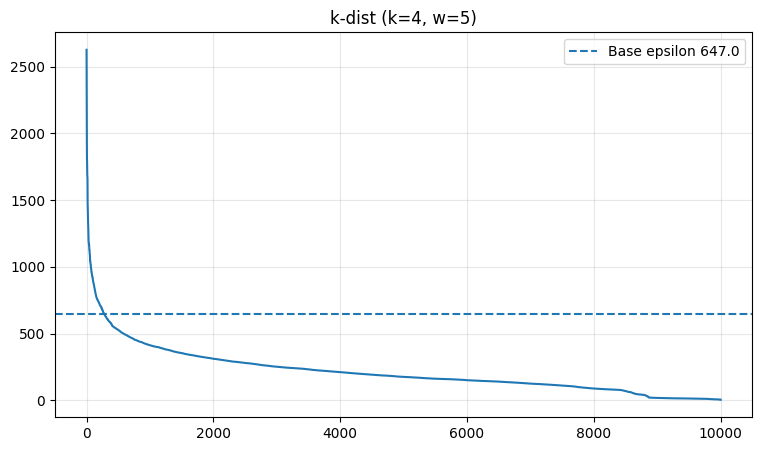

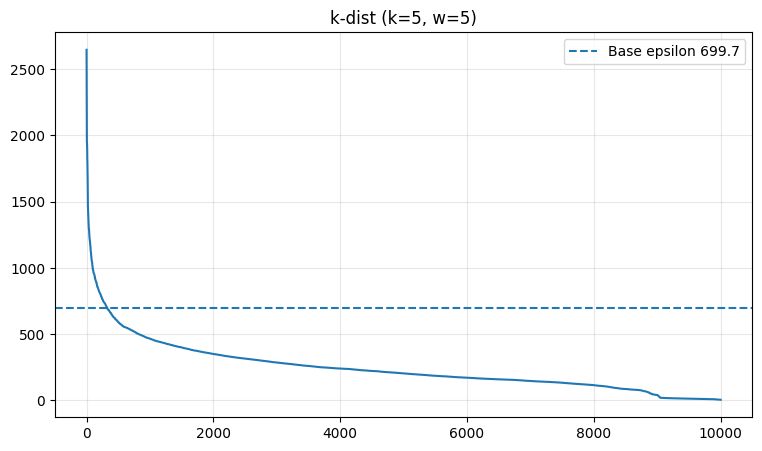

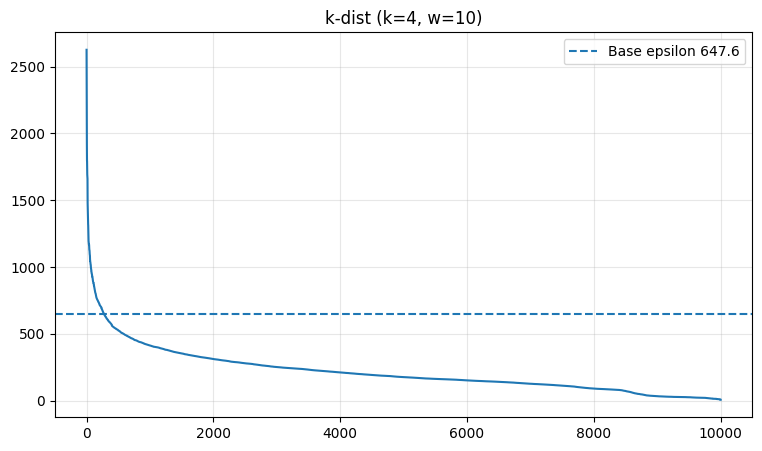

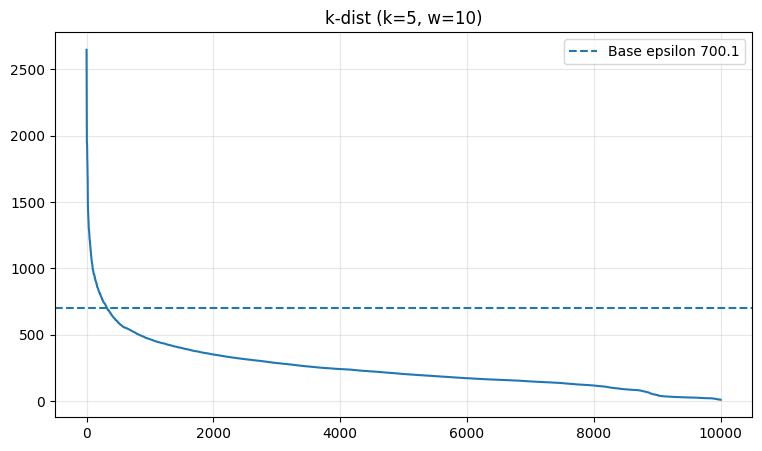

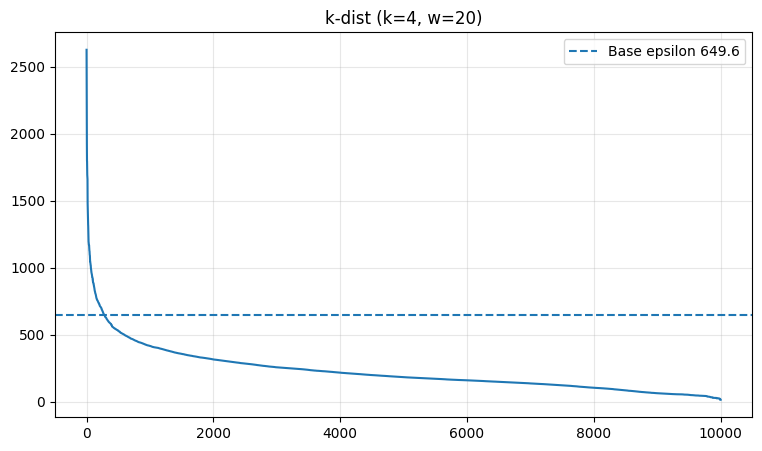

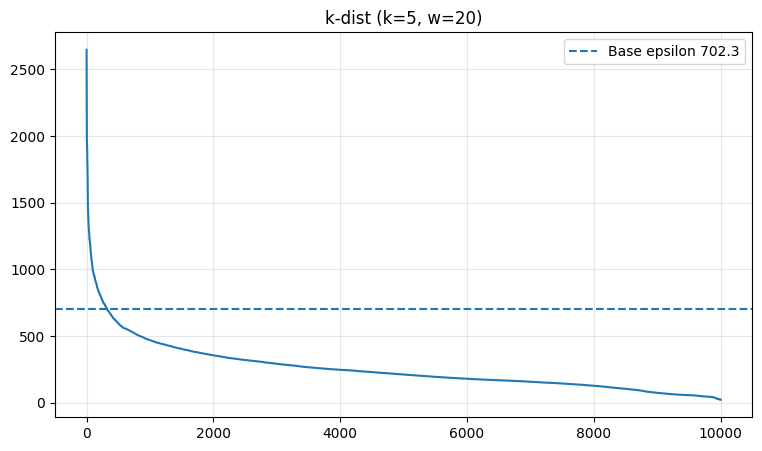

Testing: eps=200, min_samples=4, temporal_weight=5
Testing: eps=200, min_samples=5, temporal_weight=5
Testing: eps=200, min_samples=5, temporal_weight=5
Testing: eps=200, min_samples=4, temporal_weight=10
Testing: eps=200, min_samples=4, temporal_weight=10
Testing: eps=200, min_samples=5, temporal_weight=10
Testing: eps=200, min_samples=5, temporal_weight=10
Testing: eps=200, min_samples=4, temporal_weight=20
Testing: eps=200, min_samples=4, temporal_weight=20
Testing: eps=200, min_samples=5, temporal_weight=20
Testing: eps=200, min_samples=5, temporal_weight=20


,eps,min_samples,temporal_weight,n_clusters,noise_ratio,silhouette,runtime_s,avg_cluster_radius_m,median_cluster_radius_m
0,200.0,4,5.0,387,0.2600,0.028074,0.063765,141.399030,106.868480
1,200.0,4,10.0,394,0.2638,0.042500,0.050521,138.740578,105.781632
2,200.0,4,20.0,404,0.2740,0.048394,0.061000,134.098435,103.274309
3,200.0,5,5.0,325,0.3170,0.079065,0.060251,143.045183,112.663191
4,200.0,5,10.0,326,0.3218,0.101681,0.051772,142.652119,112.615554
5,200.0,5,20.0,334,0.3356,0.120095,0.048287,136.145838,106.532419



Best config (noise-primary): eps=200.0 | min_samples=4 | temporal_weight=5.0 | noise_ratio=0.260 | silhouette=0.0281 | n_clusters=387
Labeled: 10,000 rows | Clusters (excl. noise): 387 | Noise: 26.00%


In [7]:
# DBSCAN spatio-temporal pipeline and parameter sweep with k-distance pre-stage

# Choose dataset (already configured via sampling cell) and sanitize
DF_IN = df  # Use the unified dataset (full or sampled) created earlier

REQUIRED = ["Latitude", "Longitude", "HOUR", "WEEKDAY"]
missing_cols = [c for c in REQUIRED if c not in DF_IN.columns]
if missing_cols:
    raise ValueError(f"Input DataFrame is missing required columns: {missing_cols}")

DF_RUN = DF_IN.dropna(subset=REQUIRED).copy()
if len(DF_RUN) < len(DF_IN):
    print(f"Filtered {len(DF_IN)-len(DF_RUN):,} rows with NaNs in {REQUIRED} (kept {len(DF_RUN):,}).")

# Preprocessing and pipeline
def weight_func(X, w=1.0):
    return X * w

temporal_block = Pipeline([
    ("cyc", CyclicalTransformer()),
    ("sc", StandardScaler()),
    ("weight", FunctionTransformer(weight_func, kw_args={"w": 1.0}, feature_names_out="one-to-one"))
])

pre = ColumnTransformer(
    transformers=[
        ("spatial", SpatialProjectionTransformer(crs="EPSG:32618", drop_latlon=True), ["Latitude", "Longitude"]),
        ("temporal", temporal_block, ["HOUR", "WEEKDAY"])
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

pipe = Pipeline([
    ("pre", pre),
    ("cluster", DBSCAN(metric="euclidean", n_jobs=-1))
])

# Eps estimation via k-distance curve analysis
def eps_from_slope_minus_one_bucketed(kdist, slope_target=-1.0, bin_frac=0.003, smooth_bins=5, skip_head_frac=0.02):
    """Estimate eps from the descending k-distance curve using bucketed slope ≈ -1 criterion."""
    y = np.asarray(kdist, dtype=float)
    n = len(y)
    bin_size = max(50, int(n * bin_frac))
    n_bins = max(2, int(np.ceil(n / bin_size)))

    bx, by = [], []
    for b in range(n_bins):
        s = b * bin_size
        e = min(n, s + bin_size)
        if e - s < 3:
            continue
        bx.append((s + e - 1) / 2.0)
        by.append(float(np.median(y[s:e])))

    bx = np.asarray(bx); by = np.asarray(by)
    if len(bx) < 3:
        j = int(np.floor(n * 0.05))
        return float(y[j]), j, np.nan

    if smooth_bins > 1:
        ker = np.ones(int(smooth_bins), dtype=float) / int(smooth_bins)
        by_s = np.convolve(by, ker, mode='same')
    else:
        by_s = by

    slope = np.gradient(by_s, bx)
    skip = int(max(0, round(len(bx) * skip_head_frac)))
    cand = np.where(slope[skip:] >= slope_target)[0]
    if cand.size:
        j_bucket = cand[0] + skip
    else:
        j_bucket = int(np.argmin(np.abs(slope - slope_target)))

    elbow_idx = int(round(bx[j_bucket]))
    elbow_idx = int(np.clip(elbow_idx, 0, n - 1))
    return float(y[elbow_idx]), elbow_idx, float(slope[j_bucket])


def param_grid_from_kdist_pairs(
    df, preprocessor, *,
    temporal_weights=(5.0, 10.0, 20.0),
    ks=(3, 4, 5, 6, 8),
    spread=(0.3, 0.5, 0.7, 0.9, 1.0),
    plot=False,
    eps_cap=500.0,
    eps_strategy="slope-1-bucketed"
):
    grid = []
    for tw in temporal_weights:
        pre_w = clone(preprocessor).set_params(temporal__weight__kw_args={"w": tw})
        X_feats = np.asarray(pre_w.fit_transform(df))

        for k in ks:
            nbrs = NearestNeighbors(n_neighbors=k+1).fit(X_feats)
            dists, _ = nbrs.kneighbors(X_feats)
            kdist = np.sort(dists[:, k])[::-1]

            if eps_strategy == "slope-1-bucketed":
                eps_k, elbow_idx, elbow_slope = eps_from_slope_minus_one_bucketed(
                    kdist, slope_target=-1.0, bin_frac=0.003, smooth_bins=5, skip_head_frac=0.02
                )

            eps_list = sorted({
                min(eps_k * m, eps_cap) for m in spread
            })

            grid.append({
                "cluster__eps": eps_list,
                "cluster__min_samples": [k],
                "pre__temporal__weight__kw_args": [{"w": tw}],
            })

            if plot:
                plt.figure(figsize=(9,5))
                plt.plot(range(len(kdist)), kdist)
                plt.axhline(eps_k, linestyle='--', label=f'Base epsilon {eps_k:.1f}')
                plt.title(f'k-dist (k={k}, w={tw})'); plt.grid(True, alpha=0.3); plt.legend(); plt.show()

    return grid

# Build focused parameter grid via k-distance
param_grid = param_grid_from_kdist_pairs(
    DF_RUN, pre,
    temporal_weights=(5, 10, 20),
    ks=(4, 5),
    spread=(0.7, 0.8, 0.9),
    eps_cap=200.0,
    eps_strategy="slope-1-bucketed",
    plot=True
)

# Sweep helpers
def _spatial_indices_from_pre(pre_fitted):
    names = list(pre_fitted.get_feature_names_out())
    ix_x = names.index("X_METERS") if "X_METERS" in names else names.index("spatial__X_METERS")
    ix_y = names.index("Y_METERS") if "Y_METERS" in names else names.index("spatial__Y_METERS")
    return ix_x, ix_y


def _spatial_compactness(X_all, labels, ix_x, ix_y):
    out = {"avg_cluster_radius_m": np.nan, "median_cluster_radius_m": np.nan}
    uniq = np.unique(labels)
    uniq = uniq[uniq != -1]
    if uniq.size == 0:
        return out
    XY = X_all[:, [ix_x, ix_y]]
    radii = []
    for c in uniq:
        pts = XY[labels == c]
        if len(pts) < 2:
            continue
        center = pts.mean(axis=0)
        d = np.linalg.norm(pts - center, axis=1)
        radii.append(np.median(d))
    if not radii:
        return out
    out["avg_cluster_radius_m"] = float(np.mean(radii))
    out["median_cluster_radius_m"] = float(np.median(radii))
    return out

# Manual grid search over focused grid
results = []
best_params = None
# Primary objective: minimize noise ratio. Tie-breaker 1: maximize silhouette. Tie-breaker 2: maximize n_clusters.
best_noise = np.inf
best_sil_tie = -np.inf

for params in ParameterGrid(param_grid):
    print(f"Testing: eps={float(params['cluster__eps']):.6g}, min_samples={params['cluster__min_samples']}, temporal_weight={params['pre__temporal__weight__kw_args']['w']}")
    pipe.set_params(**params)
    t0 = time.perf_counter()
    labels = pipe.fit_predict(DF_RUN)
    dt = time.perf_counter() - t0

    X_all = pipe.named_steps["pre"].transform(DF_RUN)
    X_all = np.asarray(X_all)

    n_total = len(labels)
    n_noise = int(np.sum(labels == -1))
    noise_ratio = n_noise / max(n_total, 1)

    valid_mask = labels != -1
    unique_valid = np.unique(labels[valid_mask])
    sil = silhouette_score(X_all[valid_mask], labels[valid_mask], metric="euclidean") if valid_mask.sum() >= 2 and unique_valid.size >= 2 else np.nan

    ix_x, ix_y = _spatial_indices_from_pre(pipe.named_steps["pre"])
    compact = _spatial_compactness(X_all, labels, ix_x, ix_y)

    row = {
        "eps": float(params["cluster__eps"]),
        "min_samples": int(params["cluster__min_samples"]),
        "temporal_weight": float(params["pre__temporal__weight__kw_args"]["w"]),
        "n_clusters": int(np.unique(labels[labels != -1]).size),
        "noise_ratio": float(noise_ratio),
        "silhouette": float(sil) if np.isfinite(sil) else np.nan,
        "runtime_s": float(dt),
        **compact,
    }
    results.append(row)

    # Selection logic: minimize noise ratio then maximize silhouette then number of clusters
    if (noise_ratio + 1e-12) < best_noise:
        best_noise = noise_ratio
        best_sil_tie = sil if np.isfinite(sil) else -np.inf
        best_params = {
            "cluster__eps": row["eps"],
            "cluster__min_samples": row["min_samples"],
            "pre__temporal__weight__kw_args": {"w": row["temporal_weight"]},
            "_noise_ratio": noise_ratio,
            "_silhouette": sil if np.isfinite(sil) else np.nan,
            "_n_clusters": row["n_clusters"],
        }
    elif np.isclose(noise_ratio, best_noise, rtol=1e-6, atol=1e-9):
        cur_sil = sil if np.isfinite(sil) else -np.inf
        best_sil_val = best_params.get('_silhouette', -np.inf)
        if ((cur_sil > best_sil_val) or (np.isclose(cur_sil, best_sil_val, rtol=1e-6, atol=1e-9) and row["n_clusters"] > best_params.get('_n_clusters', -1))):
            best_noise = noise_ratio
            best_sil_tie = cur_sil
            best_params = {
                "cluster__eps": row["eps"],
                "cluster__min_samples": row["min_samples"],
                "pre__temporal__weight__kw_args": {"w": row["temporal_weight"]},
                "_noise_ratio": noise_ratio,
                "_silhouette": sil if np.isfinite(sil) else np.nan,
                "_n_clusters": row["n_clusters"],
            }

# Results table and best refit
res_df = pd.DataFrame(results).sort_values(
    by=["noise_ratio", "silhouette", "n_clusters"],
    ascending=[True, False, False],
    na_position="last"
).reset_index(drop=True)

display(res_df.head(15))

if best_params is None:
    raise RuntimeError("No valid configuration found (DBSCAN produced <2 clusters across grid).")

print(
    f"\nBest config (noise-primary): eps={best_params['cluster__eps']} | "
    f"min_samples={best_params['cluster__min_samples']} | "
    f"temporal_weight={best_params['pre__temporal__weight__kw_args']['w']} | "
    f"noise_ratio={best_params['_noise_ratio']:.3f} | silhouette={best_params.get('_silhouette', float('nan')):.4f} | "
    f"n_clusters={best_params['_n_clusters']}"
)

# Clean helper keys before downstream reuse
best_params_clean = {k: v for k, v in best_params.items() if not k.startswith('_')}

best_pipe = clone(pipe).set_params(**best_params_clean).fit(DF_RUN)
best_labels = best_pipe.named_steps["cluster"].labels_

X_all_best = best_pipe.named_steps["pre"].transform(DF_RUN)
X_all_best = np.asarray(X_all_best)
ix_x_best, ix_y_best = _spatial_indices_from_pre(best_pipe.named_steps["pre"])

coords_labels_df = pd.DataFrame({
    "X_METERS": X_all_best[:, ix_x_best],
    "Y_METERS": X_all_best[:, ix_y_best],
    "cluster": best_labels
})

df_labeled = DF_RUN.copy()
df_labeled["X_METERS"] = coords_labels_df["X_METERS"].values
df_labeled["Y_METERS"] = coords_labels_df["Y_METERS"].values
df_labeled["cluster"] = coords_labels_df["cluster"].values

print(f"Labeled: {len(best_labels):,} rows | Clusters (excl. noise): {np.unique(best_labels[best_labels!=-1]).size} | Noise: {(best_labels==-1).mean():.2%}")

### Selection Criteria Update

Primary model selection metric: noise ratio (lower is better). Silhouette score acts as first tie breaker when noise ratios are near equal, followed by number of clusters.

### Best Parameters Model

In [8]:
# Use best DBSCAN pipeline: refit label data and profile clusters

# Helper to sanitize best_params coming from sweep

def _normalize_params(raw_params, pipe_obj):
    if raw_params is None:
        return {}
    valid = pipe_obj.get_params()
    cleaned = {}
    unmatched = {}
    for k, v in raw_params.items():
        if k.startswith('_'):
            continue
        if k in valid:
            cleaned[k] = v
            continue
        if '__' not in k and '_' in k:
            step, rest = k.split('_', 1)
            cand = f"{step}__{rest}"
            if cand in valid:
                cleaned[cand] = v
                continue
        unmatched[k] = v
    if unmatched:
        print(f"[param-normalizer] Dropped {len(unmatched)} unmatched keys: {list(unmatched.keys())}")
    return cleaned

# Resolve best parameters safely
if 'best_params' not in locals() or best_params is None:
    if 'res_df' in locals() and 'pipe' in locals() and not res_df.empty:
        top = res_df.iloc[0]
        best_params = {
            "cluster__eps": float(top["eps"]),
            "cluster__min_samples": int(top["min_samples"]),
            "pre__temporal__weight__kw_args": {"w": float(top["temporal_weight"])}
        }
    else:
        raise RuntimeError("Best params not found. Run the sweep cell first.")

# Choose data to fit on (respects earlier sampling decision)
df_used = df

# Normalize and fit fresh pipeline
if 'pipe' not in locals():
    raise RuntimeError("Base pipeline 'pipe' not found. Run the DBSCAN sweep section first.")

best_params_sanitized = _normalize_params(best_params, pipe)
if not best_params_sanitized:
    raise RuntimeError("After sanitization no valid best parameters remained.")

print("Fitting pipeline with parameters:")
for k, v in best_params_sanitized.items():
    print(f"  {k} = {v}")

best_pipe = clone(pipe).set_params(**best_params_sanitized).fit(df_used)
labels_all = best_pipe.named_steps["cluster"].labels_

# Attach labels
df_labeled = df_used.copy()
df_labeled["cluster"] = labels_all

# Extract X/Y in meters from fitted preprocessor

def _xy_indices(pre_fitted):
    names = list(pre_fitted.get_feature_names_out())
    ix_x = names.index("X_METERS") if "X_METERS" in names else names.index("spatial__X_METERS")
    ix_y = names.index("Y_METERS") if "Y_METERS" in names else names.index("spatial__Y_METERS")
    return ix_x, ix_y

X_all = np.asarray(best_pipe.named_steps["pre"].transform(df_used))
ix_x, ix_y = _xy_indices(best_pipe.named_steps["pre"])
df_labeled["X_METERS"] = X_all[:, ix_x]
df_labeled["Y_METERS"] = X_all[:, ix_y]

# Quick cluster profiling

def _cluster_profiles(df):
    g = df[df["cluster"] != -1].groupby("cluster", sort=True)
    centroids = g[["X_METERS","Y_METERS"]].mean().rename(columns={"X_METERS":"centroid_x_m","Y_METERS":"centroid_y_m"})
    def median_radius(gr):
        c = gr[["X_METERS","Y_METERS"]].mean().values
        d = np.linalg.norm(gr[["X_METERS","Y_METERS"]].values - c, axis=1)
        return np.median(d) if len(d) else np.nan
    radius = g.apply(median_radius).rename("median_radius_m")
    temporal_cols = [c for c in ["HOUR","WEEKDAY"] if c in df.columns]
    if temporal_cols:
        temporal_modes = g[temporal_cols].agg(lambda s: s.mode().iloc[0] if not s.mode().empty else np.nan)
        prof = pd.concat([centroids, radius, temporal_modes], axis=1)
    else:
        prof = pd.concat([centroids, radius], axis=1)
    prof["n_points"] = g.size()
    return prof.reset_index()

profiles = _cluster_profiles(df_labeled)

# Noise summary
n_total = len(df_labeled)
n_noise = int((df_labeled["cluster"] == -1).sum())
noise_ratio = n_noise / max(n_total, 1)

print(f"Total points: {n_total} | Clusters (excl. noise): {profiles.shape[0]} | Noise ratio: {noise_ratio:.3f}")
display(profiles.head(15))

# Convert centroids back to lat/lon (uses pipeline CRS if available)
try:
    crs_proj = best_pipe.named_steps["pre"].named_transformers_["spatial"].crs
except Exception:
    crs_proj = "EPSG:32618"

to_wgs84 = Transformer.from_crs(crs_proj, "EPSG:4326", always_xy=True)
lon, lat = to_wgs84.transform(profiles["centroid_x_m"].values, profiles["centroid_y_m"].values)
profiles["centroid_lat"] = lat
profiles["centroid_lon"] = lon

display(profiles[["cluster","n_points","median_radius_m","centroid_lat","centroid_lon"]].head(15))

Fitting pipeline with parameters:
  cluster__eps = 200.0
  cluster__min_samples = 4
  pre__temporal__weight__kw_args = {'w': 5.0}
Total points: 10000 | Clusters (excl. noise): 387 | Noise ratio: 0.260
Total points: 10000 | Clusters (excl. noise): 387 | Noise ratio: 0.260


,cluster,centroid_x_m,centroid_y_m,median_radius_m,HOUR,WEEKDAY,n_points
0,0,585380.236179,4.510692e+06,1673.603181,16,FRIDAY,1040
1,1,585553.163745,4.505957e+06,0.000000,11,TUESDAY,8
2,2,592089.380403,4.521040e+06,1927.932836,17,THURSDAY,1020
3,3,595532.828931,4.500566e+06,6.039707,16,SATURDAY,14
4,4,591661.535409,4.502275e+06,881.031285,19,THURSDAY,243
5,5,589003.290487,4.518002e+06,1364.168616,18,FRIDAY,566
6,6,587571.327729,4.513629e+06,255.756409,16,THURSDAY,38
7,7,574437.972379,4.498712e+06,218.776460,11,FRIDAY,17
8,8,588115.539717,4.495835e+06,234.931250,10,MONDAY,16
9,9,589251.155095,4.506530e+06,217.103173,21,SATURDAY,14


,cluster,n_points,median_radius_m,centroid_lat,centroid_lon
0,0,1040,1673.603181,40.742748,-73.988725
1,1,8,0.000000,40.700081,-73.987324
2,2,1020,1927.932836,40.835225,-73.907747
3,3,14,6.039707,40.650428,-73.870038
4,4,243,881.031285,40.666258,-73.915570
5,5,566,1364.168616,40.808204,-73.944778
6,6,38,255.756409,40.768972,-73.962366
7,7,17,218.776460,40.635900,-74.119735
8,8,16,234.931250,40.608635,-73.958417
9,9,14,217.103173,40.704851,-73.943477


### DBSCAN Cluster Visualization

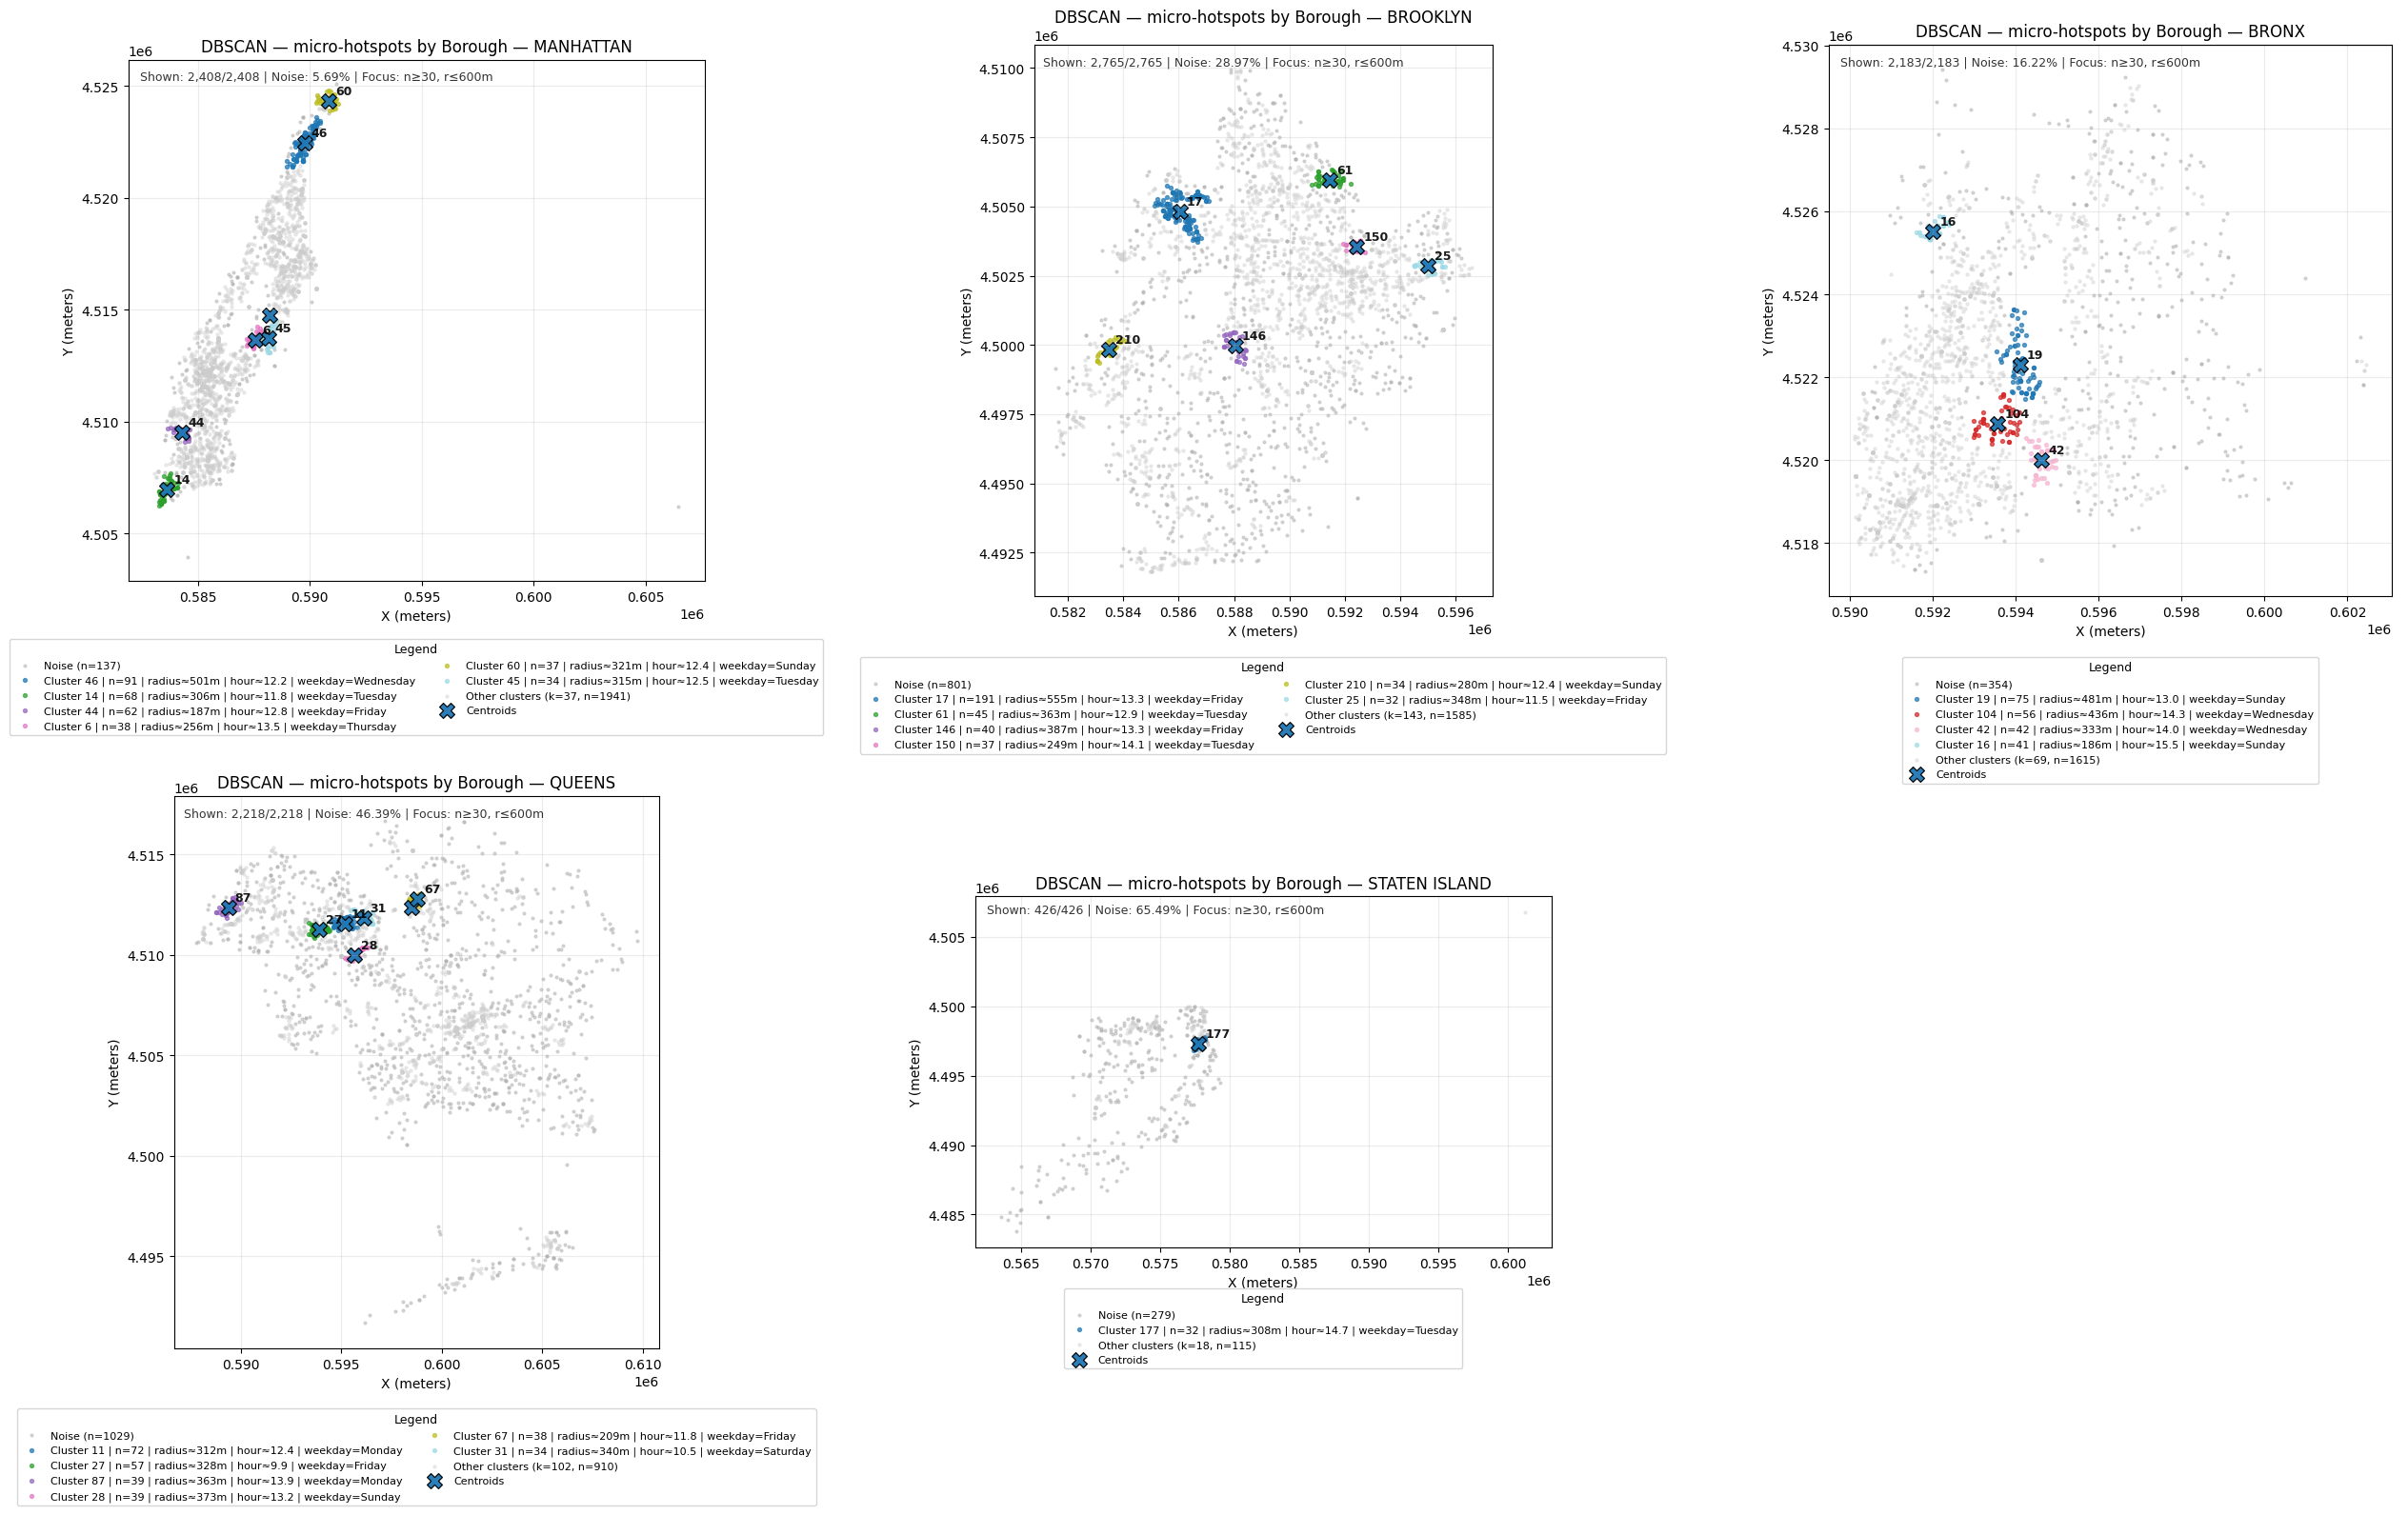

In [9]:
# Static visualization for micro-hotspots

_WEEKDAY_ORDER = ["MONDAY","TUESDAY","WEDNESDAY","THURSDAY","FRIDAY","SATURDAY","SUNDAY"]

def _median_radius_m_from_df(df):
    if df.empty:
        return np.nan
    c = df[["X_METERS","Y_METERS"]].mean().values
    d = np.linalg.norm(df[["X_METERS","Y_METERS"]].values - c, axis=1)
    return float(np.median(d)) if len(d) else np.nan

def _weekday_mode(series):
    wd = series.astype(str).str.upper()
    wd = wd.where(wd.isin(_WEEKDAY_ORDER), np.nan)
    mode = wd.mode()
    return mode.iloc[0].title() if not mode.empty else np.nan

def _legend_label(c, stats_row):
    parts = [f"Cluster {int(c)}", f"n={int(stats_row['n'])}"]
    if pd.notna(stats_row.get("median_radius_m", np.nan)):
        parts.append(f"radius≈{stats_row['median_radius_m']:.0f}m")
    if pd.notna(stats_row.get("hour_mean", np.nan)):
        parts.append(f"hour≈{stats_row['hour_mean']:.1f}")
    if isinstance(stats_row.get("weekday_mode", np.nan), str):
        parts.append(f"weekday={stats_row['weekday_mode']}")
    return " | ".join(parts)

def plot_clusters(
    df_labeled: pd.DataFrame,
    title: str = "DBSCAN (spatio-temporal micro-hotspots) — meter space",
    sample_max: int = 120_000,
    top_k_legend: int = 10,
    focus_only: bool = True,
    min_points: int = 30,
    max_radius_m: float = 800.0,
    show_centroids: bool = True,
    annotate_topk: bool = True
):
    # Safety
    needed = {"X_METERS","Y_METERS","cluster"}
    missing = needed - set(df_labeled.columns)
    if missing:
        raise ValueError(f"df_labeled is missing columns: {missing}")

    # Compute per-cluster stats
    grp = df_labeled[df_labeled["cluster"] != -1].groupby("cluster", sort=True)
    stats = pd.DataFrame({
        "n": grp.size(),
        "centroid_x_m": grp["X_METERS"].mean(),
        "centroid_y_m": grp["Y_METERS"].mean(),
        "median_radius_m": grp.apply(_median_radius_m_from_df)
    })
    if "HOUR" in df_labeled.columns:
        stats["hour_mean"] = grp["HOUR"].mean()
    if "WEEKDAY" in df_labeled.columns:
        stats["weekday_mode"] = grp["WEEKDAY"].apply(_weekday_mode)

    # Focus filter for micro-hotspots
    if focus_only:
        mask = (stats["n"] >= min_points) & (stats["median_radius_m"] <= max_radius_m)
        stats = stats[mask]

    # Fallback if empty
    if stats.empty:
        stats = pd.DataFrame({
            "n": grp.size(),
            "centroid_x_m": grp["X_METERS"].mean(),
            "centroid_y_m": grp["Y_METERS"].mean(),
            "median_radius_m": grp.apply(_median_radius_m_from_df)
        }).sort_values("n", ascending=False).head(top_k_legend)
        if "HOUR" in df_labeled.columns:
            stats["hour_mean"] = grp["HOUR"].mean()
        if "WEEKDAY" in df_labeled.columns:
            stats["weekday_mode"] = grp["WEEKDAY"].apply(_weekday_mode)

    # Determine highlight clusters
    highlight = stats.sort_values(["n", "median_radius_m"], ascending=[False, True]).head(top_k_legend)
    top_clusters = list(highlight.index)

    # Build plotting sample
    plot_df = df_labeled if len(df_labeled) <= sample_max else df_labeled.sample(sample_max, random_state=42)

    # Counts and noise
    counts = plot_df["cluster"].value_counts(dropna=False)
    n_total = int(len(plot_df))
    n_noise = int(counts.get(-1, 0))
    noise_ratio = n_noise / max(n_total, 1)

    # Colors
    cmap = plt.cm.get_cmap("tab20", max(2, len(top_clusters)))
    color_top = {c: cmap(i) for i, c in enumerate(top_clusters)}
    color_noise = (0.7, 0.7, 0.7, 0.35)
    color_other = (0.80, 0.80, 0.80, 0.35)

    fig, ax = plt.subplots(figsize=(9, 9))

    # Noise
    if n_noise > 0:
        sdf = plot_df[plot_df["cluster"] == -1]
        ax.scatter(sdf["X_METERS"], sdf["Y_METERS"], s=4, alpha=0.5, label=f"Noise (n={len(sdf)})", c=[color_noise])

    # Top clusters
    for c in top_clusters:
        sdf = plot_df[plot_df["cluster"] == c]
        label_txt = _legend_label(c, stats.loc[c])
        ax.scatter(sdf["X_METERS"], sdf["Y_METERS"], s=8, alpha=0.7, c=[color_top[c]], label=label_txt)

    # Other clusters subdued
    others = [c for c in plot_df["cluster"].unique() if c not in top_clusters and c != -1]
    if len(others) > 0:
        sdf = plot_df[plot_df["cluster"].isin(others)]
        ax.scatter(sdf["X_METERS"], sdf["Y_METERS"], s=5, alpha=0.35, label=f"Other clusters (k={len(others)}, n={len(sdf)})", c=[color_other])

    # Centroids
    if show_centroids and not stats.empty:
        ax.scatter(stats["centroid_x_m"], stats["centroid_y_m"], s=130, marker="X", linewidth=0.9, edgecolor="black", alpha=0.95, label="Centroids")
        if annotate_topk:
            ann = stats.loc[top_clusters]
            for cid, r in ann.iterrows():
                ax.annotate(f"{int(cid)}", (float(r["centroid_x_m"]), float(r["centroid_y_m"])), xytext=(5,5), textcoords="offset points", fontsize=9, weight="bold", alpha=0.9)

    ax.set_title(title, fontsize=13)
    ax.set_xlabel("X (meters)")
    ax.set_ylabel("Y (meters)")
    ax.set_aspect("equal")

    ax.text(0.02, 0.98, f"Shown: {len(plot_df):,}/{len(df_labeled):,} | Noise: {noise_ratio:.2%} | Focus: n≥{min_points}, radius≤{int(max_radius_m)}m", transform=ax.transAxes, va="top", ha="left", fontsize=9, alpha=0.8)

    leg = ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.08), ncol=1 if len(top_clusters) <= 4 else 2, frameon=True, fontsize=9)
    if leg:
        leg.set_title("Legend", prop={"size": 10})

    ax.grid(True, alpha=0.25)
    plt.tight_layout()
    plt.show()


def plot_clusters_by_zone(
    df_labeled: pd.DataFrame,
    zone_col: str | None = None,
    zones: list[str] | None = None,
    title: str = "DBSCAN — micro-hotspots by zone",
    sample_max_per_zone: int = 60_000,
    top_k_legend: int = 6,
    focus_only: bool = True,
    min_points: int = 30,
    max_radius_m: float = 800.0,
    show_centroids: bool = True,
    annotate_topk: bool = True,
    ncols: int = 3,
):
    # Safety
    required = {"X_METERS", "Y_METERS", "cluster"}
    miss = required - set(df_labeled.columns)
    if miss:
        raise ValueError(f"df_labeled is missing columns: {miss}")
    
    # Detect zone column if not provided
    zone_col = "BORO_NM"

    # Build zone list
    all_zones = [z for z in df_labeled[zone_col].dropna().unique().tolist()]
    try:
        all_zones = sorted(all_zones, key=lambda x: (str(type(x)), x))
    except Exception:
        all_zones = sorted(all_zones, key=str)
    zone_list = zones if zones is not None else all_zones
    if len(zone_list) == 0:
        raise ValueError(f"No zones found in column '{zone_col}'.")

    # Prepare facet grid
    n = len(zone_list)
    ncols = max(1, ncols)
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8.5*ncols, 8*nrows))
    axes = np.atleast_1d(axes).reshape(nrows, ncols)

    # Plot each zone
    for idx, zone in enumerate(zone_list):
        r, c = divmod(idx, ncols)
        ax = axes[r, c]
        sub = df_labeled[df_labeled[zone_col] == zone].copy()

        # If empty or only noise, just annotate
        if sub.empty or (sub["cluster"].nunique() == 1 and sub["cluster"].unique()[0] == -1):
            ax.set_title(f"{zone} — no clusters", fontsize=12)
            ax.set_xlabel("X (meters)"); ax.set_ylabel("Y (meters)"); ax.set_aspect("equal")
            ax.grid(True, alpha=0.25)
            continue

        # Compute per-cluster stats within this zone
        grp = sub[sub["cluster"] != -1].groupby("cluster", sort=True)
        stats = pd.DataFrame({
            "n": grp.size(),
            "centroid_x_m": grp["X_METERS"].mean(),
            "centroid_y_m": grp["Y_METERS"].mean(),
            "median_radius_m": grp.apply(_median_radius_m_from_df)
        })
        if "HOUR" in sub.columns:
            stats["hour_mean"] = grp["HOUR"].mean()
        if "WEEKDAY" in sub.columns:
            stats["weekday_mode"] = grp["WEEKDAY"].apply(_weekday_mode)

        # Focus filter (actionable micro-hotspots)
        if focus_only and not stats.empty:
            mask = (stats["n"] >= min_points) & (stats["median_radius_m"] <= max_radius_m)
            stats = stats[mask]

        # If still empty, fall back to top by size
        if stats.empty:
            stats = pd.DataFrame({
                "n": grp.size(),
                "centroid_x_m": grp["X_METERS"].mean(),
                "centroid_y_m": grp["Y_METERS"].mean(),
                "median_radius_m": grp.apply(_median_radius_m_from_df)
            }).sort_values("n", ascending=False).head(top_k_legend)
            if "HOUR" in sub.columns:
                stats["hour_mean"] = grp["HOUR"].mean()
            if "WEEKDAY" in sub.columns:
                stats["weekday_mode"] = grp["WEEKDAY"].apply(_weekday_mode)

        # Sort and pick Top-K for legend
        highlight = stats.sort_values(["n", "median_radius_m"], ascending=[False, True]).head(top_k_legend)
        top_clusters = list(highlight.index)

        # Sample points for speed
        plot_df = sub if len(sub) <= sample_max_per_zone else sub.sample(sample_max_per_zone, random_state=42)

        # Counts / noise
        counts = plot_df["cluster"].value_counts(dropna=False)
        n_total = int(len(plot_df))
        n_noise = int(counts.get(-1, 0))
        noise_ratio = n_noise / max(n_total, 1)

        # Colors for this zone
        cmap = plt.cm.get_cmap("tab20", max(2, len(top_clusters)))
        color_top = {cl: cmap(i) for i, cl in enumerate(top_clusters)}
        color_noise = (0.7, 0.7, 0.7, 0.35)
        color_other = (0.80, 0.80, 0.80, 0.35)

        # Plot noise
        if n_noise > 0:
            sdf = plot_df[plot_df["cluster"] == -1]
            ax.scatter(sdf["X_METERS"], sdf["Y_METERS"], s=4, alpha=0.5, label=f"Noise (n={len(sdf)})", c=[color_noise])

        # Plot top clusters with descriptive legend
        for cl in top_clusters:
            sdf = plot_df[plot_df["cluster"] == cl]
            label_txt = _legend_label(cl, stats.loc[cl])
            ax.scatter(sdf["X_METERS"], sdf["Y_METERS"], s=8, alpha=0.7, c=[color_top[cl]], label=label_txt)

        # Other clusters (subdued)
        others = [cl for cl in plot_df["cluster"].unique() if cl not in top_clusters and cl != -1]
        if len(others) > 0:
            sdf = plot_df[plot_df["cluster"].isin(others)]
            ax.scatter(sdf["X_METERS"], sdf["Y_METERS"], s=5, alpha=0.35, label=f"Other clusters (k={len(others)}, n={len(sdf)})", c=[color_other])

        # Centroids overlay
        if show_centroids and not stats.empty:
            ax.scatter(stats["centroid_x_m"], stats["centroid_y_m"], s=130, marker="X", linewidth=0.9, edgecolor="black", alpha=0.95, label="Centroids")
            if annotate_topk:
                ann = stats.loc[top_clusters]
                for cid, rrow in ann.iterrows():
                    ax.annotate(f"{int(cid)}", (float(rrow["centroid_x_m"]), float(rrow["centroid_y_m"])), xytext=(5,5), textcoords="offset points", fontsize=9, weight="bold", alpha=0.9)

        # Titles, labels
        ax.set_title(f"{title} — {zone}", fontsize=12)
        ax.set_xlabel("X (meters)"); ax.set_ylabel("Y (meters)")
        ax.set_aspect("equal")
        ax.text(0.02, 0.98, f"Shown: {len(plot_df):,}/{len(sub):,} | Noise: {noise_ratio:.2%} | Focus: n≥{min_points}, r≤{int(max_radius_m)}m", transform=ax.transAxes, va="top", ha="left", fontsize=9, alpha=0.8)
        ax.grid(True, alpha=0.25)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(6, 6))
        leg = ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.10), ncol=1 if len(top_clusters) <= 4 else 2, frameon=True, fontsize=8)
        if leg:
            leg.set_title("Legend", prop={"size": 9})

    # Remove empty axes if grid not full
    for j in range(n, nrows*ncols):
        r, c = divmod(j, ncols)
        axes[r, c].axis("off")

    plt.tight_layout()
    plt.show()

plot_clusters_by_zone(
    df_labeled,
    title="DBSCAN — micro-hotspots by Borough",
    top_k_legend=6,
    focus_only=True,
    zones=["MANHATTAN", "BROOKLYN", "BRONX", "QUEENS", "STATEN ISLAND"],
    min_points=30,
    max_radius_m=600,
    ncols=3
)

## CLARANS Evaluation

Evaluate CLARANS (Clustering Large Applications based upon Randomized Search), a randomized k‑medoids variant.

Procedure:
1. Transform coordinates into projected meter space (same preprocessing used previously).  
2. Run an elbow analysis over k (candidate cluster counts) using summed squared distance to nearest medoid.  
3. Select k via maximum curvature (distance to line from first to last cost point).  
4. Fit CLARANS with multiple local minima searches.  
5. Assess compactness (median radius), silhouette on spatial coordinates, and isotropy (std(X)/std(Y)).  
6. Visualize clusters with medoids and approximate radius circles.


Selected k (silhouette-based) = 50
Final silhouette (full data) = 0.2894
Top 15 cluster sizes:
7     565
4     547
23    495
5     492
10    469
30    448
25    414
47    345
1     320
37    309
32    293
9     259
34    258
41    251
38    228
Name: count, dtype: int64
Total clusters: 50
Final silhouette (full data) = 0.2894
Top 15 cluster sizes:
7     565
4     547
23    495
5     492
10    469
30    448
25    414
47    345
1     320
37    309
32    293
9     259
34    258
41    251
38    228
Name: count, dtype: int64
Total clusters: 50


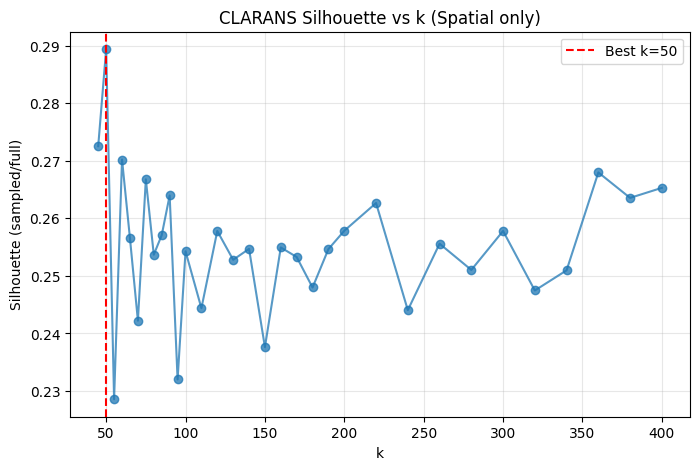

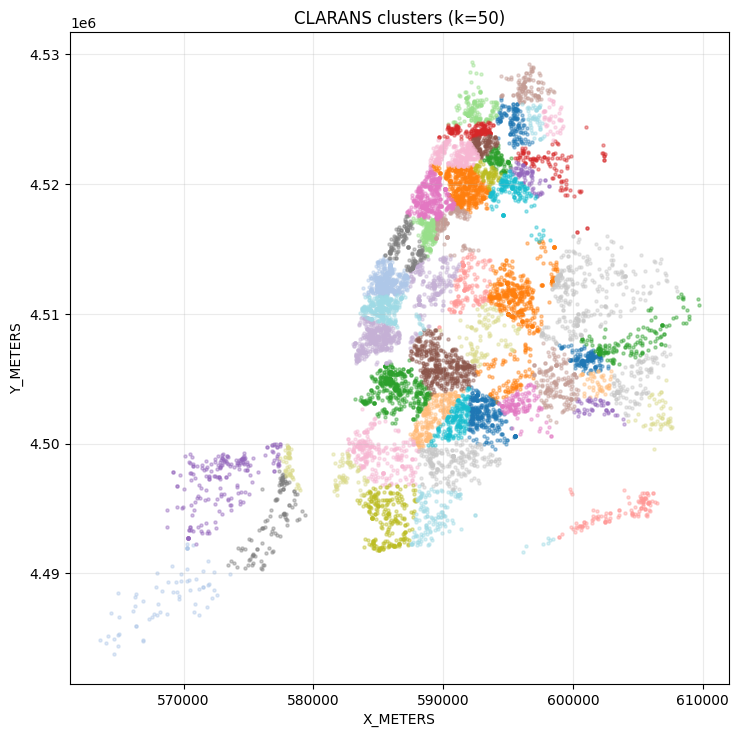

Note: Only silhouette used for model selection; cost retained for optional inspection.


In [10]:
# CLARANS high-k exploration

if 'DF_RUN' not in globals():
    raise RuntimeError("DF_RUN not found. Execute earlier preprocessing cells.")

_pre_tmp = clone(pre)
_pre_tmp.set_params(temporal__weight__kw_args={'w': 10})
X_proj = _pre_tmp.fit_transform(DF_RUN)
feat_names = list(_pre_tmp.get_feature_names_out())
try:
    ix_x = feat_names.index('X_METERS') if 'X_METERS' in feat_names else feat_names.index('spatial__X_METERS')
    ix_y = feat_names.index('Y_METERS') if 'Y_METERS' in feat_names else feat_names.index('spatial__Y_METERS')
except ValueError:
    raise RuntimeError("Projected X/Y features not found after preprocessing.")
X_spatial = np.asarray(X_proj)[:, [ix_x, ix_y]]
N = X_spatial.shape[0]

class Clarans:
    def __init__(self, n_clusters, num_local=4, max_neighbor=150, random_state=None):
        self.n_clusters = n_clusters
        self.num_local = num_local
        self.max_neighbor = max_neighbor
        self.random_state = random_state
        self.medoids_ = None
        self.labels_ = None
        self.cost_ = None
    def _total_cost(self, X, medoid_idxs):
        medoids = X[medoid_idxs]
        dists = np.linalg.norm(X[:, None, :] - medoids[None, :, :], axis=2)
        return float((dists.min(axis=1)**2).sum())
    def fit(self, X):
        rng = np.random.default_rng(self.random_state)
        n = X.shape[0]
        best_medoids, best_cost = None, np.inf
        for _ in range(self.num_local):
            medoid_idxs = rng.choice(n, self.n_clusters, replace=False)
            cur_cost = self._total_cost(X, medoid_idxs)
            neigh_ct, improved = 0, True
            while neigh_ct < self.max_neighbor and improved:
                improved = False
                m_out = rng.choice(medoid_idxs)
                candidates = np.setdiff1d(np.arange(n), medoid_idxs, assume_unique=True)
                if candidates.size == 0: break
                m_in = rng.choice(candidates)
                new_medoids = medoid_idxs.copy()
                new_medoids[np.where(new_medoids == m_out)[0][0]] = m_in
                new_cost = self._total_cost(X, new_medoids)
                neigh_ct += 1
                if new_cost < cur_cost:
                    medoid_idxs, cur_cost = new_medoids, new_cost
                    neigh_ct, improved = 0, True
            if cur_cost < best_cost:
                best_medoids, best_cost = medoid_idxs, cur_cost
        self.medoids_ = best_medoids
        self.cost_ = best_cost
        dists = np.linalg.norm(X[:, None, :] - X[best_medoids][None, :, :], axis=2)
        self.labels_ = dists.argmin(axis=1)
        return self

# K grid specification (dense at low k sparser at high k)
K_GRID = list(range(45, 101, 5)) + list(range(110, 201, 10)) + list(range(220, 401, 20))

runs = []
for k in K_GRID:
    t0 = time.perf_counter()
    clar = Clarans(n_clusters=k, num_local=3 if k <= 120 else 2, max_neighbor=120 if k <= 120 else 90, random_state=RANDOM_STATE)
    clar.fit(X_spatial)
    runtime = time.perf_counter() - t0
    if k > 1 and len(np.unique(clar.labels_)) > 1:
        if N > 25000:
            idx = np.random.default_rng(42).choice(N, 25000, replace=False)
            sil = silhouette_score(X_spatial[idx], clar.labels_[idx], metric='euclidean')
        else:
            sil = silhouette_score(X_spatial, clar.labels_, metric='euclidean')
    else:
        sil = np.nan
    runs.append({'k': k, 'cost': clar.cost_, 'silhouette': sil, 'runtime_s': runtime, 'labels': clar.labels_})

result_df = pd.DataFrame([{k: v for k, v in r.items() if k != 'labels'} for r in runs])
valid = result_df[result_df['silhouette'].notna()].copy()
if valid.empty:
    best_k = K_GRID[0]
else:
    valid = valid.sort_values(['silhouette', 'cost', 'k'], ascending=[False, True, False])
    best_k = int(valid.iloc[0]['k'])

print(f"Selected k (silhouette-based) = {best_k}")
labels_clar = next(r['labels'] for r in runs if r['k'] == best_k)
try:
    final_sil = silhouette_score(X_spatial, labels_clar, metric='euclidean') if best_k > 1 else np.nan
except Exception:
    final_sil = np.nan
print(f"Final silhouette (full data) = {final_sil:.4f}")

sizes = pd.Series(labels_clar).value_counts().sort_values(ascending=False)
print("Top 15 cluster sizes:")
print(sizes.head(15))
print(f"Total clusters: {sizes.shape[0]}")

plt.figure(figsize=(8,5))
plt.plot(result_df['k'], result_df['silhouette'], marker='o', linestyle='-', alpha=0.75)
plt.axvline(best_k, color='red', linestyle='--', label=f'Best k={best_k}')
plt.title('CLARANS Silhouette vs k (Spatial only)')
plt.xlabel('k'); plt.ylabel('Silhouette (sampled/full)')
plt.grid(alpha=0.3); plt.legend(); plt.show()

plt.figure(figsize=(8.5,8.5))
colors = plt.cm.get_cmap('tab20', max(2, best_k))
for c in sorted(sizes.index):
    pts = X_spatial[labels_clar == c]
    if len(pts) > 5000:
        idx = np.random.default_rng(123).choice(len(pts), 5000, replace=False)
        pts_plot = pts[idx]
    else:
        pts_plot = pts
    plt.scatter(pts_plot[:,0], pts_plot[:,1], s=5, alpha=0.4, color=colors(c))
plt.title(f'CLARANS clusters (k={best_k})')
plt.xlabel('X_METERS'); plt.ylabel('Y_METERS'); plt.gca().set_aspect('equal')
plt.grid(alpha=0.25)
plt.show()

print('Note: Only silhouette used for model selection; cost retained for optional inspection.')

# Build labeled DataFrame for downstream selection
if 'DF_RUN' in globals():
    df_labeled_clar = DF_RUN.copy()
    df_labeled_clar['X_METERS'] = X_spatial[:,0]
    df_labeled_clar['Y_METERS'] = X_spatial[:,1]
    df_labeled_clar['cluster'] = labels_clar
else:
    df_labeled_clar = None

### Cluster Source Selection

Choose which clustering output to use for subsequent visualization and analysis. Two labeled DataFrames are available if both sections were executed:

- DBSCAN: `df_labeled` from the noise‑focused spatio‑temporal density clustering.
- CLARANS: `df_labeled_clar` from k‑medoids on the same features.

Set `CLUSTER_SOURCE` in the next code cell to `'dbscan'` or `'clarans'`. If the chosen source is unavailable, a fallback or error will be raised.

In [11]:
# Choose clustering result for downstream analysis
# Options: 'dbscan' or 'clarans'
CLUSTER_SOURCE = 'dbscan'

# Validate and collect sources
_available_sources = {}
if 'df_labeled' in globals() and isinstance(df_labeled, pd.DataFrame):
    _available_sources['dbscan'] = df_labeled
if 'df_labeled_clar' in globals() and isinstance(df_labeled_clar, pd.DataFrame):
    _available_sources['clarans'] = df_labeled_clar

if CLUSTER_SOURCE not in _available_sources:
    raise ValueError(f"Requested CLUSTER_SOURCE='{CLUSTER_SOURCE}' not available. Available: {list(_available_sources.keys())}")

# Unified reference used downstream
_df_selected = _available_sources[CLUSTER_SOURCE].copy()

# Standardize expected columns
_required_cols = {'cluster'}
_missing = _required_cols - set(_df_selected.columns)
if _missing:
    raise ValueError(f"Selected source missing required columns: {_missing}")

print(f"Using clustering source: {CLUSTER_SOURCE} | rows={len(_df_selected):,} | clusters(excl. noise if -1 used)={(_df_selected['cluster'].ne(-1).sum() if 'cluster' in _df_selected else 'n/a')} ")

# Overwrite canonical variable consumed later
df_labeled = _df_selected

Using clustering source: dbscan | rows=10,000 | clusters(excl. noise if -1 used)=7400 


## Spatio-Temporal Hotspots

In [12]:
# Temporal pattern analysis of spatio-temporal clusters

def analyze_cluster_temporal_patterns(df_labeled, min_cluster_size=10):
    """Analyze temporal patterns within existing spatio-temporal clusters."""
    # Filter out noise first
    df_no_noise = df_labeled[df_labeled['cluster'] != -1].copy()
    
    if df_no_noise.empty:
        print("No valid clusters found (all are noise)")
        return pd.DataFrame()
    
    # Get cluster sizes and filter by minimum size
    cluster_sizes = df_no_noise['cluster'].value_counts()
    valid_clusters = cluster_sizes[cluster_sizes >= min_cluster_size].index
    
    if len(valid_clusters) == 0:
        print(f"No clusters found with at least {min_cluster_size} incidents")
        return pd.DataFrame()
    
    # Filter data to only include valid clusters
    df_clean = df_no_noise[df_no_noise['cluster'].isin(valid_clusters)].copy()
    
    print(f"Processing {len(valid_clusters)} clusters with {len(df_clean)} total incidents")
    
    # Define time slots for analysis
    time_slots = {
        'night': (0, 6),
        'morning': (6, 12), 
        'afternoon': (12, 18),
        'evening': (18, 24)
    }
    
    # Add time slot classification
    def classify_time_slot(hour):
        for slot_name, (start, end) in time_slots.items():
            if start <= hour < end:
                return slot_name
        return 'unknown'
    
    df_clean['time_slot'] = df_clean['HOUR'].apply(classify_time_slot)
    
    # Group by cluster for analysis
    cluster_patterns = []
    
    for cluster_id in sorted(valid_clusters):
        cluster_data = df_clean[df_clean['cluster'] == cluster_id]
        
        # Basic cluster info
        pattern = {
            'cluster_id': int(cluster_id),
            'total_incidents': len(cluster_data),
            'centroid_lat': cluster_data['Latitude'].mean(),
            'centroid_lon': cluster_data['Longitude'].mean(),
        }
        
        # Temporal intensity by time slots
        time_slot_counts = cluster_data['time_slot'].value_counts()
        total_incidents = len(cluster_data)
        
        for slot in time_slots.keys():
            count = time_slot_counts.get(slot, 0)
            pattern[f'{slot}_count'] = count
            pattern[f'{slot}_percentage'] = (count / total_incidents) * 100
        
        # Dominant time slot
        pattern['dominant_time_slot'] = time_slot_counts.index[0] if not time_slot_counts.empty else 'unknown'
        pattern['dominant_slot_percentage'] = time_slot_counts.iloc[0] / total_incidents * 100 if not time_slot_counts.empty else 0
        
        # Hour statistics
        pattern['peak_hour'] = int(cluster_data['HOUR'].mode().iloc[0]) if not cluster_data['HOUR'].mode().empty else None
        pattern['hour_mean'] = cluster_data['HOUR'].mean()
        pattern['hour_std'] = cluster_data['HOUR'].std()
        
        # Weekday patterns
        weekday_counts = cluster_data['WEEKDAY'].value_counts()
        pattern['dominant_weekday'] = weekday_counts.index[0] if not weekday_counts.empty else 'unknown'
        pattern['weekday_concentration'] = weekday_counts.iloc[0] / total_incidents * 100 if not weekday_counts.empty else 0
        
        # Weekend vs weekday distribution
        if 'IS_WEEKEND' in cluster_data.columns:
            weekend_count = cluster_data['IS_WEEKEND'].sum()
            pattern['weekend_percentage'] = (weekend_count / total_incidents) * 100
            pattern['weekday_percentage'] = ((total_incidents - weekend_count) / total_incidents) * 100
        else:
            weekend_days = ['SATURDAY', 'SUNDAY']
            weekend_count = cluster_data['WEEKDAY'].isin(weekend_days).sum()
            pattern['weekend_percentage'] = (weekend_count / total_incidents) * 100
            pattern['weekday_percentage'] = ((total_incidents - weekend_count) / total_incidents) * 100
        
        # Temporal consistency metrics
        pattern['temporal_diversity'] = len(cluster_data['HOUR'].unique()) / 24.0
        pattern['weekday_diversity'] = len(cluster_data['WEEKDAY'].unique()) / 7.0
        
        # Activity density (incidents per month)
        if 'YEAR' in cluster_data.columns and 'MONTH' in cluster_data.columns:
            date_range = cluster_data.groupby(['YEAR', 'MONTH']).size()
            pattern['monthly_activity_mean'] = date_range.mean()
            pattern['monthly_activity_std'] = date_range.std()
        
        cluster_patterns.append(pattern)
    
    return pd.DataFrame(cluster_patterns)

def classify_cluster_types(patterns_df):
    """Classify clusters based on temporal patterns into operational categories."""
    if patterns_df.empty:
        return patterns_df
    
    def determine_cluster_type(row):
        if row['dominant_slot_percentage'] >= 60:
            return f"concentrated_{row['dominant_time_slot']}"
        elif row['weekend_percentage'] >= 70:
            return "weekend_focused"
        elif row['weekday_percentage'] >= 80:
            return "weekday_focused"
        elif row['temporal_diversity'] >= 0.7:
            return "all_day_activity"
        elif row['temporal_diversity'] <= 0.3:
            return "time_specific"
        else:
            return "mixed_pattern"
    
    patterns_df = patterns_df.copy()
    patterns_df['cluster_type'] = patterns_df.apply(determine_cluster_type, axis=1)
    return patterns_df

def create_operational_hotspots(patterns_df, top_n_per_type=3):
    """Create operational hotspot recommendations based on cluster temporal patterns."""
    if patterns_df.empty:
        return pd.DataFrame()
    ranked_hotspots = []
    for cluster_type in patterns_df['cluster_type'].unique():
        type_clusters = patterns_df[patterns_df['cluster_type'] == cluster_type]
        top_clusters = type_clusters.nlargest(top_n_per_type, 'total_incidents')
        for _, cluster in top_clusters.iterrows():
            hotspot = {
                'hotspot_id': f"{cluster_type}_{cluster['cluster_id']}",
                'cluster_id': cluster['cluster_id'],
                'type': cluster_type,
                'priority_rank': len(ranked_hotspots) + 1,
                'total_incidents': cluster['total_incidents'],
                'centroid_lat': cluster['centroid_lat'],
                'centroid_lon': cluster['centroid_lon'],
                'recommended_patrol_time': cluster['dominant_time_slot'],
                'recommended_patrol_days': 'weekend' if cluster_type == 'weekend_focused' else 'weekdays' if cluster_type == 'weekday_focused' else 'all_week',
                'peak_hour': cluster['peak_hour'],
                'activity_consistency': 'high' if cluster['dominant_slot_percentage'] >= 70 else 'medium'
            }
            ranked_hotspots.append(hotspot)
    return pd.DataFrame(ranked_hotspots)

# Execute temporal pattern analysis
if 'df_labeled' not in locals() or df_labeled is None:
    raise RuntimeError("df_labeled not found. Run the clustering analysis first.")

print("Analyzing temporal patterns in spatio-temporal clusters...")

# Check available clusters and adjust minimum size dynamically
valid_cluster_sizes = df_labeled[df_labeled['cluster'] != -1]['cluster'].value_counts()
if valid_cluster_sizes.empty:
    print("No valid clusters found in df_labeled!")
    cluster_patterns = pd.DataFrame()
else:
    min_size_options = [4, 3, 2, 1]
    for min_size in min_size_options:
        eligible_clusters = (valid_cluster_sizes >= min_size).sum()
        if eligible_clusters >= 3:
            print(f"Using min_cluster_size={min_size} (found {eligible_clusters} eligible clusters)")
            break
    else:
        min_size = 1
        print(f"Using min_cluster_size={min_size} (including all clusters)")
    cluster_patterns = analyze_cluster_temporal_patterns(df_labeled, min_cluster_size=min_size)

if cluster_patterns.empty:
    print("No clusters found with sufficient size for temporal analysis.")
    print("This might indicate an issue with the clustering results or data filtering.")
else:
    print(f"Analyzed {len(cluster_patterns)} clusters with temporal patterns")
    cluster_patterns = classify_cluster_types(cluster_patterns)
    print("\nCluster type distribution:")
    type_counts = cluster_patterns['cluster_type'].value_counts()
    for cluster_type, count in type_counts.items():
        print(f"  {cluster_type}: {count} clusters")
    print("\nDetailed temporal patterns:")
    display_cols = [
        'cluster_id', 'total_incidents', 'cluster_type', 'dominant_time_slot', 
        'dominant_slot_percentage', 'dominant_weekday', 'weekend_percentage',
        'peak_hour', 'temporal_diversity'
    ]
    display(cluster_patterns[display_cols].head(15))
    operational_hotspots = create_operational_hotspots(cluster_patterns, top_n_per_type=5)
    if not operational_hotspots.empty:
        print("\nOperational hotspot recommendations:")
        operational_cols = [
            'hotspot_id', 'cluster_id', 'type', 'total_incidents',
            'recommended_patrol_time', 'recommended_patrol_days', 'peak_hour'
        ]
        display(operational_hotspots[operational_cols])
    print(f"\nTemporal analysis summary:")
    print(f"Total clusters analyzed: {len(cluster_patterns)}")
    print(f"Operational hotspots identified: {len(operational_hotspots)}")
    print(f"Average incidents per cluster: {cluster_patterns['total_incidents'].mean():.1f}")
    print(f"Most common pattern: {type_counts.index[0]} ({type_counts.iloc[0]} clusters)")

Analyzing temporal patterns in spatio-temporal clusters...
Using min_cluster_size=4 (found 382 eligible clusters)
Processing 382 clusters with 7385 total incidents
Analyzed 382 clusters with temporal patterns

Cluster type distribution:
  time_specific: 103 clusters
  weekday_focused: 86 clusters
  mixed_pattern: 71 clusters
  concentrated_afternoon: 40 clusters
  concentrated_evening: 32 clusters
  all_day_activity: 28 clusters
  concentrated_morning: 8 clusters
  weekend_focused: 7 clusters
  concentrated_night: 7 clusters

Detailed temporal patterns:
Analyzed 382 clusters with temporal patterns

Cluster type distribution:
  time_specific: 103 clusters
  weekday_focused: 86 clusters
  mixed_pattern: 71 clusters
  concentrated_afternoon: 40 clusters
  concentrated_evening: 32 clusters
  all_day_activity: 28 clusters
  concentrated_morning: 8 clusters
  weekend_focused: 7 clusters
  concentrated_night: 7 clusters

Detailed temporal patterns:


,cluster_id,total_incidents,cluster_type,dominant_time_slot,dominant_slot_percentage,dominant_weekday,weekend_percentage,peak_hour,temporal_diversity
0,0,1040,all_day_activity,afternoon,38.269231,FRIDAY,24.038462,16,1.000000
1,1,8,time_specific,morning,50.000000,TUESDAY,25.000000,11,0.291667
2,2,1020,all_day_activity,afternoon,33.235294,THURSDAY,25.490196,17,1.000000
3,3,14,mixed_pattern,evening,50.000000,SATURDAY,50.000000,16,0.375000
4,4,243,all_day_activity,afternoon,33.744856,THURSDAY,20.164609,19,1.000000
5,5,566,all_day_activity,afternoon,34.805654,FRIDAY,22.084806,18,1.000000
6,6,38,all_day_activity,afternoon,44.736842,THURSDAY,26.315789,16,0.750000
7,7,17,weekday_focused,evening,47.058824,FRIDAY,17.647059,11,0.458333
8,8,16,mixed_pattern,morning,31.250000,MONDAY,25.000000,10,0.500000
9,9,14,mixed_pattern,evening,42.857143,SATURDAY,42.857143,21,0.375000



Operational hotspot recommendations:


,hotspot_id,cluster_id,type,total_incidents,recommended_patrol_time,recommended_patrol_days,peak_hour
0,all_day_activity_0,0,all_day_activity,1040,afternoon,all_week,16
1,all_day_activity_2,2,all_day_activity,1020,afternoon,all_week,17
2,all_day_activity_5,5,all_day_activity,566,afternoon,all_week,18
3,all_day_activity_4,4,all_day_activity,243,afternoon,all_week,19
4,all_day_activity_17,17,all_day_activity,191,afternoon,all_week,14
...,...,...,...,...,...,...,...
40,concentrated_morning_94,94,concentrated_morning,10,morning,all_week,10
41,concentrated_morning_329,329,concentrated_morning,7,morning,all_week,9
42,concentrated_morning_165,165,concentrated_morning,5,morning,all_week,8
43,concentrated_morning_286,286,concentrated_morning,5,morning,all_week,6



Temporal analysis summary:
Total clusters analyzed: 382
Operational hotspots identified: 45
Average incidents per cluster: 19.3
Most common pattern: time_specific (103 clusters)


Creating temporal pattern visualizations...


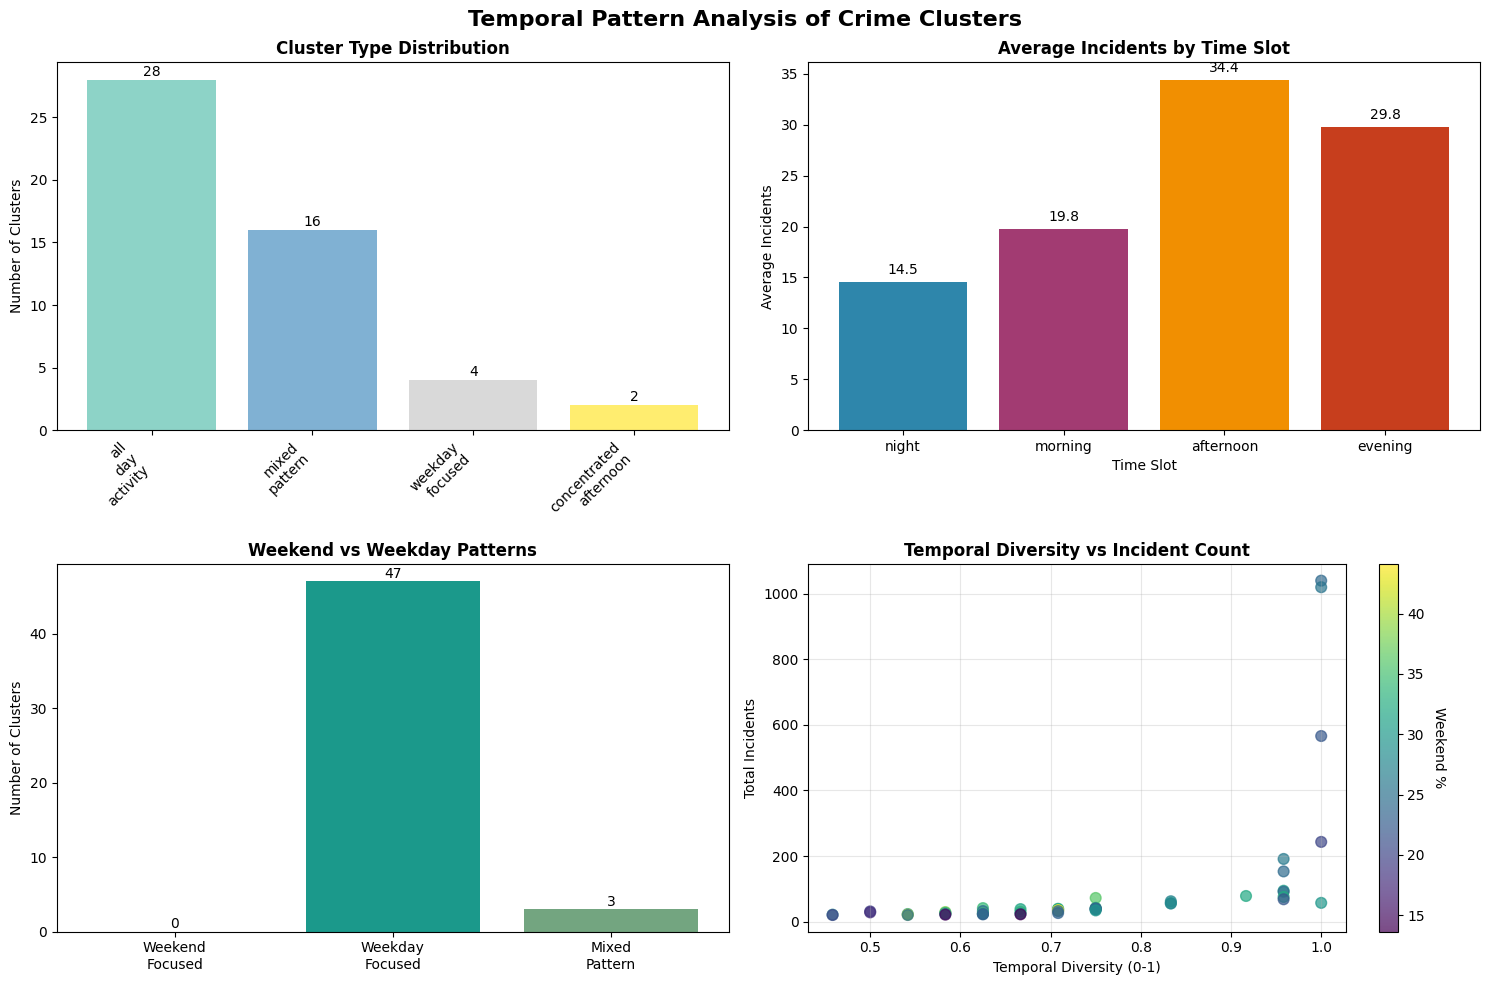

Rendering 150 clusters
Interactive map created successfully!
Interactive map created successfully!
Map saved as: c:\UNIVERSITA MAG\Data mining and Machine learning\Progetto\crime-analyzer\JupyterOutputs\Clustering (SpatialHotspots)\cluster_temporal_patterns_map.html
Map saved as: c:\UNIVERSITA MAG\Data mining and Machine learning\Progetto\crime-analyzer\JupyterOutputs\Clustering (SpatialHotspots)\cluster_temporal_patterns_map.html


In [13]:
# Interactive visualization of temporal patterns by cluster

# Helper to compute median spatial radius in meters for a cluster

def _median_radius_m_points(df_points):
    if df_points.empty:
        return float('nan')
    if {'X_METERS','Y_METERS'}.issubset(df_points.columns):
        c = df_points[["X_METERS","Y_METERS"]].mean().values
        d = np.linalg.norm(df_points[["X_METERS","Y_METERS"]].values - c, axis=1)
        return float(np.median(d)) if len(d) else float('nan')
    if {'Latitude','Longitude'}.issubset(df_points.columns):
        lat0 = df_points['Latitude'].mean()
        dy = (df_points['Latitude'] - lat0) * 111_000
        lon0 = df_points['Longitude'].mean()
        dx = (df_points['Longitude'] - lon0) * 111_000 * math.cos(math.radians(lat0))
        d = np.sqrt(dx**2 + dy**2)
        return float(np.median(d)) if len(d) else float('nan')
    return float('nan')

def create_temporal_pattern_map(
    cluster_patterns,
    df_labeled,
    top_n=100,
    min_incidents=10,
    min_radius_m: float | None = None,
    max_radius_m: float | None = None,
    radius_stats_source: str = 'computed',
    show_extent: bool = True,
    min_extent_buffer_m: float = 50.0,
    adaptive_extent: bool = True
):
    """Create interactive temporal-pattern crime cluster map."""
    if cluster_patterns.empty or df_labeled.empty:
        return None
    filtered_patterns = cluster_patterns[cluster_patterns['total_incidents'] >= min_incidents].copy()
    if filtered_patterns.empty:
        print(f"No clusters with > {min_incidents} incidents (threshold: {min_incidents})")
        return None
    if radius_stats_source == 'patterns' and 'median_radius_m' in filtered_patterns.columns:
        pass
    else:
        med_r_list = []
        for cid in filtered_patterns['cluster_id']:
            pts = df_labeled[df_labeled['cluster'] == cid]
            med_r_list.append(_median_radius_m_points(pts))
        filtered_patterns['median_radius_m'] = med_r_list
    if min_radius_m is not None:
        filtered_patterns = filtered_patterns[filtered_patterns['median_radius_m'] >= min_radius_m]
    if max_radius_m is not None:
        filtered_patterns = filtered_patterns[filtered_patterns['median_radius_m'] <= max_radius_m]
    if filtered_patterns.empty:
        print("No clusters after radius filtering.")
        return None
    if 'temporal_diversity' not in filtered_patterns.columns:
        print('temporal_diversity column missing; cannot sort by it.')
        top_clusters = filtered_patterns.head(top_n)
    else:
        top_clusters = filtered_patterns.sort_values('temporal_diversity', ascending=True).head(top_n)
    print(f"Rendering {len(top_clusters)} clusters")
    type_colors = {
        'concentrated_night': '#2E86AB',
        'concentrated_morning': '#A23B72',
        'concentrated_afternoon': '#F18F01',
        'concentrated_evening': '#C73E1D',
        'weekend_focused': '#592E83',
        'weekday_focused': '#1B998B',
        'all_day_activity': '#8D5524',
        'time_specific': '#D81159',
        'mixed_pattern': '#73A580'
    }
    center_lat = top_clusters['centroid_lat'].mean()
    center_lon = top_clusters['centroid_lon'].mean()
    m = folium.Map(location=[center_lat, center_lon], zoom_start=10, tiles="CartoDB positron")
    def _make_extent_polygon(cluster_row, cluster_points):
        coords = cluster_points[['Latitude', 'Longitude']].values
        mp = MultiPoint([Point(lon, lat) for lat, lon in coords])
        hull = mp.convex_hull
        median_r = cluster_row.get('median_radius_m', float('nan'))
        if adaptive_extent:
            base_r_m = median_r if (isinstance(median_r, (int,float)) and not math.isnan(median_r)) else min_extent_buffer_m
            base_r_m = max(base_r_m, min_extent_buffer_m)
        else:
            base_r_m = min_extent_buffer_m
        lat0 = cluster_points['Latitude'].mean()
        deg_lat = base_r_m / 111_000
        deg_lon = deg_lat / max(math.cos(math.radians(lat0)), 1e-6)
        if hull.geom_type in ('Point','LineString') or not hasattr(hull, 'exterior'):
            n_vertices = 24
            lats = []
            lons = []
            lon0 = cluster_points['Longitude'].mean()
            for k in range(n_vertices):
                ang = 2*math.pi*k/n_vertices
                lats.append(lat0 + deg_lat * math.sin(ang))
                lons.append(lon0 + deg_lon * math.cos(ang))
            return list(zip(lats, lons))
        else:
            return [[lat, lon] for lon, lat in hull.exterior.coords]
    for cluster_type in top_clusters['cluster_type'].unique():
        type_clusters = top_clusters[top_clusters['cluster_type'] == cluster_type]
        color = type_colors.get(cluster_type, '#808080')
        fg = folium.FeatureGroup(name=f"{cluster_type.replace('_', ' ').title()} ({len(type_clusters)})")
        for _, cluster in type_clusters.iterrows():
            cid = cluster['cluster_id']
            pts = df_labeled[df_labeled['cluster'] == cid]
            if pts.empty:
                continue
            popup_content = f"""
            <div style=\"width: 300px; font-family: Arial;\">
                <h4 style=\"margin: 5px 0; color: {color};\">Cluster {cid}</h4>
                <hr style=\"margin: 8px 0;\">
                <b>Type:</b> {cluster_type.replace('_',' ').title()}<br>
                <b>Total Incidents:</b> {cluster['total_incidents']}<br>
                <b>Dominant Time:</b> {cluster['dominant_time_slot'].title()} ({cluster['dominant_slot_percentage']:.1f}%)<br>
                <b>Peak Hour:</b> {cluster['peak_hour']:02d}:00<br>
                <b>Dominant Day:</b> {cluster['dominant_weekday'].title()}<br>
                <b>Weekend Activity:</b> {cluster['weekend_percentage']:.1f}%<br>
                <b>Time Diversity:</b> {cluster['temporal_diversity']:.2f}<br>
                <b>Median Radius:</b> {cluster.get('median_radius_m', float('nan')):.0f} m
            </div>
            """
            if show_extent and {'Latitude','Longitude'}.issubset(pts.columns):
                try:
                    hull_coords = _make_extent_polygon(cluster, pts)
                    folium.Polygon(
                        locations=hull_coords,
                        color=color,
                        weight=1,
                        fillColor=color,
                        fillOpacity=0.12,
                        popup=folium.Popup(popup_content, max_width=320),
                        tooltip=f"Extent cluster {cid}"
                    ).add_to(fg)
                except Exception:
                    pass
            marker_size = min(8 + np.log1p(cluster['total_incidents']) * 2, 25)
            folium.CircleMarker(
                location=[cluster['centroid_lat'], cluster['centroid_lon']],
                radius=marker_size,
                color='black',
                weight=1,
                fillColor=color,
                fillOpacity=0.85,
                popup=folium.Popup(popup_content, max_width=320),
                tooltip=f"Cluster {cid}: {cluster['total_incidents']} incidents | r≈{cluster.get('median_radius_m', float('nan')):.0f}m"
            ).add_to(fg)
        fg.add_to(m)
    folium.LayerControl(collapsed=False).add_to(m)
    legend_html = f'''<div style="position: fixed; top: 10px; right: 10px; width: 240px; background-color: white; border:2px solid grey; z-index:9999; font-size:11px; padding: 10px; border-radius: 5px;">\n'''
    legend_html += f"<h4 style='margin:0 0 6px 0;'>Temporal Clusters</h4>"
    legend_html += f"<p style='margin:4px 0;'>Shown most relevant {len(top_clusters)}/{len(cluster_patterns)}</p>"
    legend_html += "<hr style='margin:6px 0;'>"
    for ctype in sorted(top_clusters['cluster_type'].unique()):
        color = type_colors.get(ctype, '#808080')
        count = len(top_clusters[top_clusters['cluster_type'] == ctype])
        legend_html += f"<p style='margin:3px 0;'><span style='color:{color}; font-size:14px;'>●</span> {ctype.replace('_',' ').title()} ({count})</p>"
    legend_html += "</div>"
    m.get_root().html.add_child(folium.Element(legend_html))
    return m

def visualize_temporal_distributions(cluster_patterns, top_n=12):
    if cluster_patterns.empty:
        return
    top_clusters = cluster_patterns.nlargest(top_n, 'total_incidents')
    time_slots = ['night', 'morning', 'afternoon', 'evening']
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Temporal Pattern Analysis of Crime Clusters', fontsize=16, fontweight='bold')
    ax1 = axes[0, 0]
    type_counts = top_clusters['cluster_type'].value_counts()
    colors = plt.cm.Set3(np.linspace(0, 1, len(type_counts)))
    bars = ax1.bar(range(len(type_counts)), type_counts.values, color=colors)
    ax1.set_title('Cluster Type Distribution', fontweight='bold')
    ax1.set_ylabel('Number of Clusters')
    ax1.set_xticks(range(len(type_counts)))
    ax1.set_xticklabels([t.replace('_', '\n') for t in type_counts.index], rotation=45, ha='right')
    for bar in bars:
        h = bar.get_height(); ax1.text(bar.get_x()+bar.get_width()/2., h+0.1, f'{int(h)}', ha='center', va='bottom')
    ax2 = axes[0, 1]
    slot_means = [top_clusters[f'{slot}_count'].mean() for slot in time_slots]
    bars = ax2.bar(time_slots, slot_means, color=['#2E86AB', '#A23B72', '#F18F01', '#C73E1D'])
    ax2.set_title('Average Incidents by Time Slot', fontweight='bold'); ax2.set_ylabel('Average Incidents'); ax2.set_xlabel('Time Slot')
    for bar in bars:
        h = bar.get_height(); ax2.text(bar.get_x()+bar.get_width()/2., h+0.5, f'{h:.1f}', ha='center', va='bottom')
    ax3 = axes[1, 0]
    weekend_focused = top_clusters[top_clusters['weekend_percentage'] >= 60]
    weekday_focused = top_clusters[top_clusters['weekend_percentage'] <= 40]
    mixed_pattern = top_clusters[(top_clusters['weekend_percentage'] > 40) & (top_clusters['weekend_percentage'] < 60)]
    pattern_counts = [len(weekend_focused), len(weekday_focused), len(mixed_pattern)]
    pattern_labels = ['Weekend\nFocused', 'Weekday\nFocused', 'Mixed\nPattern']
    colors = ['#592E83', '#1B998B', '#73A580']
    bars = ax3.bar(pattern_labels, pattern_counts, color=colors)
    ax3.set_title('Weekend vs Weekday Patterns', fontweight='bold'); ax3.set_ylabel('Number of Clusters')
    for bar in bars:
        h = bar.get_height(); ax3.text(bar.get_x()+bar.get_width()/2., h+0.1, f'{int(h)}', ha='center', va='bottom')
    ax4 = axes[1, 1]
    scatter = ax4.scatter(top_clusters['temporal_diversity'], top_clusters['total_incidents'], c=top_clusters['weekend_percentage'], cmap='viridis', s=60, alpha=0.7)
    ax4.set_title('Temporal Diversity vs Incident Count', fontweight='bold'); ax4.set_xlabel('Temporal Diversity (0-1)'); ax4.set_ylabel('Total Incidents'); ax4.grid(True, alpha=0.3)
    cbar = plt.colorbar(scatter, ax=ax4); cbar.set_label('Weekend %', rotation=270, labelpad=15)
    plt.tight_layout(); plt.show()

# Create visualizations
if 'cluster_patterns' in locals() and not cluster_patterns.empty:
    print("Creating temporal pattern visualizations...")
    visualize_temporal_distributions(cluster_patterns, top_n=50)
    pattern_map = create_temporal_pattern_map(
        cluster_patterns,
        df_labeled,
        top_n=150,
        min_incidents=6,
        min_radius_m=10,
        max_radius_m=1000,
        show_extent=True,
        min_extent_buffer_m=40.0
    )
    if pattern_map is not None:
        print("Interactive map created successfully!")
        pattern_map_path = os.path.join(output_dir, "cluster_temporal_patterns_map.html")
        pattern_map.save(pattern_map_path)
        print(f"Map saved as: {pattern_map_path}")
        pattern_map
    else:
        print("Could not create interactive map - insufficient data after filtering")
else:
    print("No cluster patterns available for visualization")

## Comparative Clustering-Focused Hotspot Methods

| Reference | Core Objective | Cluster / Hotspot Strategy | Spatio-Temporal Handling | Strengths | Limitation vs This Workflow |
|-----------|----------------|-----------------------------|--------------------------|-----------|------------------------------|
| **Ester et al. (1996) DBSCAN** | Density-based spatial clustering | ε-neighborhood + minPts; labels dense core/edge vs noise | Spatial only (time-sliced subsets) | Arbitrary shapes; noise handling | No native temporal dynamics (needs manual temporal encoding) |
| **Birant & Kut (2007) ST-DBSCAN** | Density + temporal attributes | Spatial ε, temporal ε, attribute weighting | Joint spatial-temporal density | Integrates time directly | More parameters; scaling challenges |
| **Kulldorff et al. (2005) Space–Time Permutation** | Outbreak / hotspot detection without population at risk | Cylindrical space×time scanning + permutation baseline | Joint space–time scan statistic | Detects emerging clusters without denominator data | Window shape constraints; assumes temporal homogeneity in null |
| **Zhang & Suresh (2012) ST Pattern Mining** | Spatio-temporal pattern extraction | Pattern-growth cohesive ST-clusters | Joint discovery | Multi-scale recurring patterns | Potential overgeneration |
| **Clarans (Ng & Han 1994)** | Medoid clustering randomized search | k-medoids variant | Spatial (extendable) | Actual point medoids | Requires k a priori |
| **Present Workflow** | Operational hotspot extraction + profiling | Adaptive clustering + profiling | Temporal windows + contextual features | Modular, interpretable | No explicit statistical significance test |


## Conclusion

The **Hotspot Analysis Workflow**:
- Provides **adaptive DBSCAN parameter selection** (k‑distance slope ≈ −1) reducing manual blind grid search.
- Achieves **low-noise spatio‑temporal clustering** while preserving structure (silhouette & cluster-count tie breaks).
- Delivers **operational cluster profiling** (centroids, median radius, temporal modes, pattern categories).
- Generates **actionable hotspot recommendations** with temporal targeting and interactive mapping for operational police deployment planning.
- Maintains a **modular, extensible pipeline** (projection, temporal encoding, context features, algorithm swaps).

The resulting clusters show coherent, stable spatio‑temporal concentration patterns and are directly usable to plan targeted patrol deployments in critical temporal windows.

**Future Work**:
- **Variable-density methods**: HDBSCAN / OPTICS to handle heterogeneous densities without a single global eps.
- **Native joint density**: ST‑DBSCAN or **temporal decay weighting** to emphasize recent incidents.
- **Incremental / streaming clustering**: DenStream or sliding‑window refresh for near real‑time updates.
- **Statistical validation layers**: space–time scan statistics to attach significance to micro‑hotspots.
- **Representation + density pipelines**: UMAP / autoencoder + HDBSCAN for richer context fusion.

These extensions can further improve robustness and adaptivity while preserving interpretability and transparency of the current workflow.